<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/Test_S1_Optuna_VAE_3_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation 
---

In [1]:
# !pip install captum
# !pip install umap-learn
# !pip install datashader
# !pip install bokeh
# !pip install holoviews
!pip install tensorboardX
!pip install optuna
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
VAE Experiment 1 **[]** 2/27
---

In [3]:
import torch   
import torch.nn as nn                          
import torch.nn.functional as F                
import torch.optim as optim   
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd 
import numpy as np
import os                             

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns    

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

import torchvision
from torchvision import datasets

#based on sensor data can you determine the stimulus that is currently in use?
import optuna
from optuna.pruners import ThresholdPruner
from optuna import TrialPruned

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [7]:
df = pd.read_csv("/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/Subject_1/S1_E1_A1.csv")
#drops all 0 labels (no label)
indices_to_drop = df[df["stimulus"] == 0].index
df.drop(indices_to_drop, inplace=True)

#Removes number of features from data
# df.drop('Cyber Glove (angles of the joints) Sensor 1', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 2', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 3', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 4', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 5', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 6', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 7', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 8', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 9', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 10', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 11', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 12', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 13', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 14', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 15', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 16', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 17', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 18', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 19', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 20', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 21', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 22', inplace=True, axis=1)

In [8]:
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
767,1,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
768,1,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
769,1,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
770,1,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
771,1,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


In [9]:
X = df.drop('stimulus', axis=1)
#y = df['stimulus']
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()

(80601, 41) <class 'pandas.core.frame.DataFrame'> (80601, 1) <class 'pandas.core.frame.DataFrame'>



In [10]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
767,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
768,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
769,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
770,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
771,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


---
Visualization number of labels

stimulus
8           6795
5           6782
6           6776
7           6776
11          6773
1           6753
12          6701
10          6696
2           6656
4           6654
9           6626
3           6613
dtype: int64

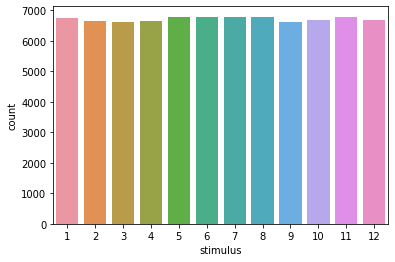

In [11]:
sns.countplot(x = 'stimulus', data=df)
y.value_counts()

---
Fixing Data Imbalance via Undersampling

<Axes: xlabel='stimulus'>

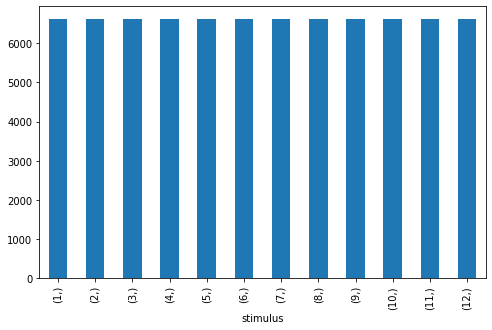

In [12]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = "not minority"
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts().plot(kind='bar', figsize=(8,5))

In [13]:
print(y_res.value_counts())
print(len(X_res.value_counts()))

stimulus
1           6613
2           6613
3           6613
4           6613
5           6613
6           6613
7           6613
8           6613
9           6613
10          6613
11          6613
12          6613
dtype: int64
79356


In [14]:
print(y)

        stimulus
767            1
768            1
769            1
770            1
771            1
...          ...
130195        12
130196        12
130197        12
130198        12
130199        12

[80601 rows x 1 columns]


---
Visualization of Data Distributions

In [15]:
# #distribution of first 19 features


# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(40, 40))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 20:
#     break 
# plt.tight_layout()

---
Defining Hyperparmaeters

In [16]:
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

#Hyperparameters
emg_channels = 16
imu_channels = 3

latent_dim = 2
input_dim= len(X.columns)

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
output_dim = len(X.columns)
num_classes = 12
num_layers = round(num_classes/2)
tempature = 1

num_epochs= 10
batch_size= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0


alpha = 2        # Reconstruction Loss
beta = 2         # Kl Divergence Loss
gamma = 3        # Classifcation Loss
delta = 5        # Contrastive Loss
epsilon = 3      # Triplet Loss

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train Test Split

In [17]:
X = X_res.values
y = y_res.values
print(X.shape, type(X), y.shape, type(y))
print()

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

(79356, 41) <class 'numpy.ndarray'> (79356, 1) <class 'numpy.ndarray'>

X_train size: 47613 | X_val size: 15871 | X_test size: 15872
y_train size: 47613 | y_val size: 15871 | y_test size: 15872

Training Feature Split: (47613, 41) | Training Labels (47613, 1)
Validation Feature Split: (15871, 41) | Validation Labels (15871, 1)
Testing Feature Split: (15872, 41) | Testing Labels (15872, 1)



---
Scaling/Normalizing Data

In [18]:
#Normalization Data 

#No Normalization 
# X_train_Normalized = X_train
# X_val_Normalized = X_val
# X_test_Normalized = X_test
#----------------------------------------------------------------------------------------------------------
# Minmax without preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train)
# X_val_Normalized = Minmax.transform(X_val)
# X_test_Normalized = Minmax.transform(X_test)
#----------------------------------------------------------------------------------------------------------
# Minmax with preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train_preprocessed)
# X_val_Normalized = Minmax.transform(X_val_preprocessed)
# X_test_Normalized = Minmax.transform(X_test_preprocessed)

#----------------------------------------------------------------------------------------------------------
# # Standardization without preprocessing
Standardized = preprocessing.StandardScaler()
X_train_Normalized= Standardized.fit_transform(X_train)
X_val_Normalized = Standardized.transform(X_val)
X_test_Normalized = Standardized.transform(X_test)

# Standardization with preprocessing
# Standardized = preprocessing.StandardScaler()
# X_train_Normalized= Standardized.fit_transform(X_train_preprocessed)
# X_val_Normalized = Standardized.transform(X_val_preprocessed)
# X_test_Normalized = Standardized.transform(X_test_preprocessed)
#----------------------------------------------------------------------------------------------------------

#Convert to numpy then to torch 

X_train = torch.from_numpy(X_train_Normalized).float()
y_train = torch.from_numpy(y_train).long()

X_val = torch.from_numpy(X_val_Normalized).float()
y_val = torch.from_numpy(y_val).long()

X_test = torch.from_numpy(X_test_Normalized).float()
y_test = torch.from_numpy(y_test).long()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , { y_train.shape}")
print(f"Validation: {X_val.shape} , { y_val.shape}")
print(f"Testing:  {X_test.shape} , { y_test.shape}")

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([47613, 41]) , torch.Size([47613, 1])
Validation: torch.Size([15871, 41]) , torch.Size([15871, 1])
Testing:  torch.Size([15872, 41]) , torch.Size([15872, 1])


---
Defining Dataloaders


In [19]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [20]:
training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

def get_data_loader(optuna_batch_size):
  train_loader = DataLoader(training, batch_size=optuna_batch_size, shuffle=True)
  val_loader = DataLoader(validating, batch_size=optuna_batch_size, shuffle=False)
  test_loader = DataLoader(testing, batch_size=optuna_batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

---
Defining VAE Model, Loss and Optmizers

In [21]:
class VAE(nn.Module):  
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()  
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.ReLU(),
        nn.Linear(num_layers, 13),
        nn.Softmax(dim=1)
    )

  def encode(self, x):  
    z = self.encoder(x)
    z1 = self.mu(z)               
    z2 = self.logvar(z) 
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)   

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)
    classified = classified / tempature

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")
  
  print(f"Logvar: {logvar.shape}")
 
  print(f"Latent Space Z: {z_reparmeterized.shape}")
 
  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 13])


In [22]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss

In [23]:
def train_VAE(trial, model, train_loader, val_loader, optimizer, epoch,alpha,beta,gamma, delta):
  train_losses=[]
  train_accuracy = []
  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  recon_loss_fn = nn.MSELoss(reduction="sum")
  classifier_loss_fn = nn.CrossEntropyLoss()
  contrastive_loss_fn = ContrastiveLoss(margin=1)

  train_running_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = recon_loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

  
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + (delta*contrastive_loss)

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = recon_loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  trial.report(train_acc, epoch)
  if trial.should_prune():
      raise optuna.TrialPruned()

  return train_losses, val_losses, train_acc, val_acc



In [116]:
def objective(trial):
  params = {
          'optuna_batch_size' : trial.suggest_int('optuna_batch_size', 1e2, 1e3),
          'num_epochs' : num_epochs,
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
          "lr": trial.suggest_float('lr', 1e-4, 1e-2),
          "hidden_dim": trial.suggest_int('hidden_dim', 1e2, 4e2),
          'alpha': trial.suggest_int('alpha', 1e0, 1e1),
          'beta': trial.suggest_int('beta', 1e0, 1e1), 
          'gamma': trial.suggest_int('gamma', 1e0, 1e1), 
          'delta': trial.suggest_int('delta', 1e0, 1e1),        
  }

  train_loader, val_loader, test_loader = get_data_loader(params['optuna_batch_size'])
  model  = VAE(input_dim, params['hidden_dim'], latent_dim).to(device)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

  for epoch in range(params['num_epochs']):
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  return train_acc


In [130]:
sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=ThresholdPruner(lower=0.3, n_warmup_steps=2, interval_steps=1),
    direction='maximize')
study.optimize(func=objective, n_trials=100)

[I 2023-03-29 02:27:26,500] A new study created in memory with name: no-name-fce21962-e852-4318-85c7-1dc6f1f15a4f


Epoch: 1 / 10 | Reconst_loss: 19855.707 | Kldiv loss: 8482.719 | Classifcation loss: 2.402 | Constrast loss: 2721.22 | Total loss: 288867.823 | Train acc: 18.733 % ||| Val Loss: 87021.103 | Val acc: 31.735 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19605.312 | Kldiv loss: 6656.264 | Classifcation loss: 2.317 | Constrast loss: 1558.47 | Total loss: 79839.469 | Train acc: 34.716 % ||| Val Loss: 70686.217 | Val acc: 40.261 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 10 | Reconst_loss: 15610.240 | Kldiv loss: 5417.118 | Classifcation loss: 2.207 | Constrast loss: 1389.14 | Total loss: 66656.645 | Train acc: 46.827 % ||| Val Loss: 60744.684 | Val acc: 56.831 %
--------------

[I 2023-03-29 02:27:51,106] Trial 0 finished with value: 0.7884965078659139 and parameters: {'optuna_batch_size': 758, 'optimizer': 'Adam', 'lr': 0.009096949614525337, 'hidden_dim': 130, 'alpha': 9, 'beta': 8, 'gamma': 9, 'delta': 9}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 13846.905 | Kldiv loss: 4215.271 | Classifcation loss: 1.892 | Constrast loss: 221.25 | Total loss: 46943.307 | Train acc: 78.850 % ||| Val Loss: 46797.588 | Val acc: 79.419 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 16264.984 | Kldiv loss: 6850.256 | Classifcation loss: 2.461 | Constrast loss: 2123.10 | Total loss: 295938.975 | Train acc: 17.052 % ||| Val Loss: 65734.523 | Val acc: 21.192 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13901.153 | Kldiv loss: 4191.885 | Classifcation loss: 2.398 | Constrast loss: 1199.27 | Total loss: 57482.257 | Train acc: 28.706 % ||| Val Loss: 50602.898 | Val acc: 33.837 %
--------------

[I 2023-03-29 02:28:11,968] Trial 1 finished with value: 0.7111893191535065 and parameters: {'optuna_batch_size': 536, 'optimizer': 'Adam', 'lr': 0.002206116725957672, 'hidden_dim': 104, 'alpha': 5, 'beta': 7, 'gamma': 8, 'delta': 10}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 10171.082 | Kldiv loss: 3313.704 | Classifcation loss: 2.028 | Constrast loss: 277.90 | Total loss: 33687.211 | Train acc: 71.119 % ||| Val Loss: 33730.957 | Val acc: 71.118 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10756.885 | Kldiv loss: 4579.590 | Classifcation loss: 2.499 | Constrast loss: 907.92 | Total loss: 242405.269 | Train acc: 14.507 % ||| Val Loss: 83915.959 | Val acc: 20.295 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9329.696 | Kldiv loss: 3707.069 | Classifcation loss: 2.394 | Constrast loss: 404.36 | Total loss: 73862.797 | Train acc: 21.410 % ||| Val Loss: 65364.142 | Val acc: 29.511 %
-----------------

[I 2023-03-29 02:28:50,748] Trial 2 finished with value: 0.696409588219755 and parameters: {'optuna_batch_size': 706, 'optimizer': 'Adam', 'lr': 0.0052861856157798755, 'hidden_dim': 326, 'alpha': 9, 'beta': 6, 'gamma': 3, 'delta': 10}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 6607.567 | Kldiv loss: 2177.025 | Classifcation loss: 2.007 | Constrast loss: 86.85 | Total loss: 41798.158 | Train acc: 69.641 % ||| Val Loss: 42485.387 | Val acc: 70.781 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14418.499 | Kldiv loss: 3866.882 | Classifcation loss: 2.385 | Constrast loss: 1544.81 | Total loss: 37280383.839 | Train acc: 21.396 % ||| Val Loss: 49098.851 | Val acc: 30.990 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 12924.383 | Kldiv loss: 3251.438 | Classifcation loss: 2.283 | Constrast loss: 801.01 | Total loss: 43456.922 | Train acc: 37.747 % ||| Val Loss: 39479.306 | Val acc: 41.201 %
---------------

[I 2023-03-29 02:29:16,420] Trial 3 finished with value: 0.5898151882591186 and parameters: {'optuna_batch_size': 418, 'optimizer': 'RMSprop', 'lr': 0.009153465908498845, 'hidden_dim': 194, 'alpha': 8, 'beta': 1, 'gamma': 10, 'delta': 7}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 9298.271 | Kldiv loss: 2247.189 | Classifcation loss: 2.076 | Constrast loss: 348.50 | Total loss: 29538.236 | Train acc: 58.982 % ||| Val Loss: 27328.673 | Val acc: 62.631 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1487.615 | Kldiv loss: 729.916 | Classifcation loss: 2.488 | Constrast loss: 13.87 | Total loss: 5213763179.811 | Train acc: 13.853 % ||| Val Loss: 96833.915 | Val acc: 22.553 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1425.131 | Kldiv loss: 632.075 | Classifcation loss: 2.371 | Constrast loss: 6.55 | Total loss: 89353.017 | Train acc: 28.004 % ||| Val Loss: 80729.630 | Val acc: 33.272 %
--------------------

[I 2023-03-29 02:30:00,983] Trial 4 finished with value: 0.7029821821126926 and parameters: {'optuna_batch_size': 670, 'optimizer': 'RMSprop', 'lr': 0.0025301409972689555, 'hidden_dim': 390, 'alpha': 7, 'beta': 4, 'gamma': 5, 'delta': 2}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 984.799 | Kldiv loss: 264.409 | Classifcation loss: 2.074 | Constrast loss: 0.25 | Total loss: 46349.962 | Train acc: 70.298 % ||| Val Loss: 45108.489 | Val acc: 72.034 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11381.719 | Kldiv loss: 5641.282 | Classifcation loss: 2.494 | Constrast loss: 1106.97 | Total loss: 446990.268 | Train acc: 10.114 % ||| Val Loss: 92549.200 | Val acc: 16.327 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 10820.163 | Kldiv loss: 4299.705 | Classifcation loss: 2.414 | Constrast loss: 697.78 | Total loss: 83653.755 | Train acc: 23.126 % ||| Val Loss: 73430.784 | Val acc: 32.436 %
--------------------

[I 2023-03-29 02:30:26,100] Trial 5 finished with value: 0.6858915289256199 and parameters: {'optuna_batch_size': 750, 'optimizer': 'Adam', 'lr': 0.0030905484692926696, 'hidden_dim': 197, 'alpha': 5, 'beta': 4, 'gamma': 10, 'delta': 3}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 8877.095 | Kldiv loss: 2719.551 | Classifcation loss: 2.055 | Constrast loss: 189.09 | Total loss: 47097.800 | Train acc: 68.589 % ||| Val Loss: 45613.327 | Val acc: 69.067 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1392.125 | Kldiv loss: 349.184 | Classifcation loss: 2.484 | Constrast loss: 16.15 | Total loss: 23681.256 | Train acc: 14.885 % ||| Val Loss: 17389.429 | Val acc: 19.339 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1047.444 | Kldiv loss: 288.746 | Classifcation loss: 2.382 | Constrast loss: 10.03 | Total loss: 16132.510 | Train acc: 28.740 % ||| Val Loss: 15127.400 | Val acc: 32.529 %
------------------------

[I 2023-03-29 02:31:08,759] Trial 6 finished with value: 0.6243251513980156 and parameters: {'optuna_batch_size': 199, 'optimizer': 'RMSprop', 'lr': 0.000575869589163284, 'hidden_dim': 264, 'alpha': 8, 'beta': 10, 'gamma': 1, 'delta': 5}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 1130.848 | Kldiv loss: 308.900 | Classifcation loss: 2.055 | Constrast loss: 13.12 | Total loss: 11635.853 | Train acc: 62.433 % ||| Val Loss: 11508.994 | Val acc: 63.243 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 969.830 | Kldiv loss: 781.108 | Classifcation loss: 2.476 | Constrast loss: 16.03 | Total loss: 490726937548672.312 | Train acc: 13.379 % ||| Val Loss: 136778.494 | Val acc: 21.578 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 916.174 | Kldiv loss: 583.804 | Classifcation loss: 2.430 | Constrast loss: 8.37 | Total loss: 119133.836 | Train acc: 23.789 % ||| Val Loss: 102136.327 | Val acc: 32.313 %
----------------

[I 2023-03-29 02:31:34,010] Trial 7 finished with value: 0.6388507455019553 and parameters: {'optuna_batch_size': 721, 'optimizer': 'RMSprop', 'lr': 0.005164642043301015, 'hidden_dim': 201, 'alpha': 8, 'beta': 10, 'gamma': 6, 'delta': 3}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 990.395 | Kldiv loss: 209.600 | Classifcation loss: 2.171 | Constrast loss: 5.40 | Total loss: 57379.752 | Train acc: 63.885 % ||| Val Loss: 56734.312 | Val acc: 64.026 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.239 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-29 02:31:41,121] Trial 8 pruned. 


Epoch: 3 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 19993.021 | Kldiv loss: 9246.551 | Classifcation loss: 2.508 | Constrast loss: 3259.72 | Total loss: 251617.944 | Train acc: 16.146 % ||| Val Loss: 95720.194 | Val acc: 22.199 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19168.775 | Kldiv loss: 8309.730 | Classifcation loss: 2.478 | Constrast loss: 2051.35 | Total loss: 92628.795 | Train acc: 24.133 % ||| Val Loss: 80962.274 | Val acc: 27.455 %
---------------------------------------------

[I 2023-03-29 02:32:18,708] Trial 9 finished with value: 0.5270186236485777 and parameters: {'optuna_batch_size': 783, 'optimizer': 'RMSprop', 'lr': 0.0008113129628773764, 'hidden_dim': 354, 'alpha': 8, 'beta': 2, 'gamma': 8, 'delta': 6}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 15465.987 | Kldiv loss: 4724.014 | Classifcation loss: 2.293 | Constrast loss: 792.44 | Total loss: 55957.035 | Train acc: 52.702 % ||| Val Loss: 53632.824 | Val acc: 53.346 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11995.760 | Kldiv loss: 6150.256 | Classifcation loss: 2.519 | Constrast loss: 734.06 | Total loss: 681284.230 | Train acc: 12.293 % ||| Val Loss: 131030.151 | Val acc: 14.459 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 10397.109 | Kldiv loss: 4135.762 | Classifcation loss: 2.389 | Constrast loss: 382.27 | Total loss: 115342.379 | Train acc: 21.883 % ||| Val Loss: 100490.003 | Val acc: 31.757 %
-------------

[I 2023-03-29 02:32:40,497] Trial 10 finished with value: 0.663259193731834 and parameters: {'optuna_batch_size': 965, 'optimizer': 'Adam', 'lr': 0.0072270753320828555, 'hidden_dim': 105, 'alpha': 2, 'beta': 8, 'gamma': 4, 'delta': 8}. Best is trial 0 with value: 0.7884965078659139.


Epoch: 10 / 10 | Reconst_loss: 7264.408 | Kldiv loss: 2234.576 | Classifcation loss: 2.045 | Constrast loss: 150.17 | Total loss: 61383.762 | Train acc: 66.326 % ||| Val Loss: 60406.539 | Val acc: 66.807 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10995.688 | Kldiv loss: 2695.765 | Classifcation loss: 2.322 | Constrast loss: 767.83 | Total loss: 109227.309 | Train acc: 23.950 % ||| Val Loss: 36294.136 | Val acc: 42.388 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9438.623 | Kldiv loss: 2649.494 | Classifcation loss: 2.084 | Constrast loss: 441.56 | Total loss: 33215.754 | Train acc: 57.667 % ||| Val Loss: 29867.328 | Val acc: 70.338 %
------------------

[I 2023-03-29 02:33:02,402] Trial 11 finished with value: 0.8006433045979487 and parameters: {'optuna_batch_size': 463, 'optimizer': 'Adam', 'lr': 0.007229824661539796, 'hidden_dim': 114, 'alpha': 4, 'beta': 7, 'gamma': 8, 'delta': 10}. Best is trial 11 with value: 0.8006433045979487.


Epoch: 10 / 10 | Reconst_loss: 9557.537 | Kldiv loss: 2335.492 | Classifcation loss: 1.904 | Constrast loss: 190.17 | Total loss: 27867.353 | Train acc: 80.064 % ||| Val Loss: 27969.310 | Val acc: 78.100 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6043.650 | Kldiv loss: 1393.084 | Classifcation loss: 2.263 | Constrast loss: 223.47 | Total loss: 57299.216 | Train acc: 25.661 % ||| Val Loss: 27290.095 | Val acc: 41.059 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4272.300 | Kldiv loss: 1127.974 | Classifcation loss: 2.097 | Constrast loss: 86.89 | Total loss: 23698.396 | Train acc: 56.081 % ||| Val Loss: 21371.218 | Val acc: 66.213 %
---------------------

[I 2023-03-29 02:33:29,917] Trial 12 finished with value: 0.8110167870646909 and parameters: {'optuna_batch_size': 334, 'optimizer': 'Adam', 'lr': 0.00777693016754971, 'hidden_dim': 148, 'alpha': 3, 'beta': 7, 'gamma': 9, 'delta': 9}. Best is trial 12 with value: 0.8110167870646909.


Epoch: 10 / 10 | Reconst_loss: 3712.881 | Kldiv loss: 1000.003 | Classifcation loss: 1.905 | Constrast loss: 17.78 | Total loss: 17929.738 | Train acc: 81.102 % ||| Val Loss: 18573.395 | Val acc: 79.952 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 494.171 | Kldiv loss: 142.613 | Classifcation loss: 2.188 | Constrast loss: 0.00 | Total loss: 41636.225 | Train acc: 27.284 % ||| Val Loss: 23515.873 | Val acc: 49.490 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 505.183 | Kldiv loss: 105.457 | Classifcation loss: 2.115 | Constrast loss: 2.57 | Total loss: 19923.599 | Train acc: 59.572 % ||| Val Loss: 19080.258 | Val acc: 65.953 %
-----------------------------

[I 2023-03-29 02:33:59,900] Trial 13 finished with value: 0.8140587842220085 and parameters: {'optuna_batch_size': 292, 'optimizer': 'Adam', 'lr': 0.007181249217335203, 'hidden_dim': 152, 'alpha': 2, 'beta': 5, 'gamma': 7, 'delta': 8}. Best is trial 13 with value: 0.8140587842220085.


Epoch: 10 / 10 | Reconst_loss: 351.555 | Kldiv loss: 94.950 | Classifcation loss: 1.811 | Constrast loss: 0.00 | Total loss: 15121.426 | Train acc: 81.406 % ||| Val Loss: 15550.637 | Val acc: 81.116 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3432.508 | Kldiv loss: 822.689 | Classifcation loss: 2.245 | Constrast loss: 113.61 | Total loss: 32978.398 | Train acc: 28.461 % ||| Val Loss: 17382.208 | Val acc: 51.227 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2983.650 | Kldiv loss: 791.669 | Classifcation loss: 2.053 | Constrast loss: 66.67 | Total loss: 16284.490 | Train acc: 61.334 % ||| Val Loss: 15587.054 | Val acc: 66.557 %
----------------------------

[I 2023-03-29 02:34:34,019] Trial 14 finished with value: 0.7762448895966619 and parameters: {'optuna_batch_size': 246, 'optimizer': 'Adam', 'lr': 0.007256261571613527, 'hidden_dim': 155, 'alpha': 1, 'beta': 4, 'gamma': 6, 'delta': 8}. Best is trial 13 with value: 0.8140587842220085.


Epoch: 10 / 10 | Reconst_loss: 2674.914 | Kldiv loss: 766.382 | Classifcation loss: 1.913 | Constrast loss: 14.35 | Total loss: 13513.551 | Train acc: 77.624 % ||| Val Loss: 13641.713 | Val acc: 76.517 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3224.096 | Kldiv loss: 713.630 | Classifcation loss: 2.342 | Constrast loss: 68.33 | Total loss: 54961.963 | Train acc: 24.254 % ||| Val Loss: 27536.914 | Val acc: 41.196 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2258.167 | Kldiv loss: 671.674 | Classifcation loss: 2.203 | Constrast loss: 23.43 | Total loss: 24945.625 | Train acc: 46.669 % ||| Val Loss: 22614.660 | Val acc: 51.470 %
--------------------------

[I 2023-03-29 02:35:11,117] Trial 15 finished with value: 0.6772933906604812 and parameters: {'optuna_batch_size': 337, 'optimizer': 'Adam', 'lr': 0.006487492882106226, 'hidden_dim': 254, 'alpha': 3, 'beta': 5, 'gamma': 7, 'delta': 8}. Best is trial 13 with value: 0.8140587842220085.


Epoch: 10 / 10 | Reconst_loss: 1825.611 | Kldiv loss: 525.245 | Classifcation loss: 1.996 | Constrast loss: 8.51 | Total loss: 18108.447 | Train acc: 67.729 % ||| Val Loss: 18239.071 | Val acc: 67.230 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 241.989 | Kldiv loss: 57.832 | Classifcation loss: 1.984 | Constrast loss: 0.00 | Total loss: 9808.422 | Train acc: 55.517 % ||| Val Loss: 7318.134 | Val acc: 79.590 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 335.732 | Kldiv loss: 71.797 | Classifcation loss: 1.894 | Constrast loss: 0.00 | Total loss: 7121.956 | Train acc: 83.289 % ||| Val Loss: 6953.275 | Val acc: 85.073 %
-------------------------------------

[I 2023-03-29 02:36:08,822] Trial 16 finished with value: 0.9188792724072148 and parameters: {'optuna_batch_size': 119, 'optimizer': 'Adam', 'lr': 0.008330466639603, 'hidden_dim': 157, 'alpha': 1, 'beta': 6, 'gamma': 9, 'delta': 7}. Best is trial 16 with value: 0.9188792724072148.


Epoch: 10 / 10 | Reconst_loss: 249.571 | Kldiv loss: 72.347 | Classifcation loss: 1.691 | Constrast loss: 0.00 | Total loss: 6165.823 | Train acc: 91.888 % ||| Val Loss: 6204.972 | Val acc: 90.973 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1427.608 | Kldiv loss: 335.339 | Classifcation loss: 2.274 | Constrast loss: 47.19 | Total loss: 17440.022 | Train acc: 26.452 % ||| Val Loss: 11695.810 | Val acc: 43.220 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1205.224 | Kldiv loss: 261.133 | Classifcation loss: 2.239 | Constrast loss: 23.58 | Total loss: 10746.375 | Train acc: 45.948 % ||| Val Loss: 9282.649 | Val acc: 50.554 %
--------------------------------

[I 2023-03-29 02:37:30,355] Trial 17 finished with value: 0.4030192299626728 and parameters: {'optuna_batch_size': 113, 'optimizer': 'Adam', 'lr': 0.009999911575307111, 'hidden_dim': 288, 'alpha': 1, 'beta': 3, 'gamma': 5, 'delta': 5}. Best is trial 16 with value: 0.9188792724072148.


Epoch: 10 / 10 | Reconst_loss: 1311.771 | Kldiv loss: 249.435 | Classifcation loss: 2.310 | Constrast loss: 7.97 | Total loss: 7027.407 | Train acc: 40.302 % ||| Val Loss: 8342.379 | Val acc: 40.077 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3818.332 | Kldiv loss: 818.906 | Classifcation loss: 2.145 | Constrast loss: 122.35 | Total loss: 16543.778 | Train acc: 34.603 % ||| Val Loss: 9728.227 | Val acc: 57.148 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3013.921 | Kldiv loss: 692.151 | Classifcation loss: 2.126 | Constrast loss: 82.08 | Total loss: 9021.704 | Train acc: 59.569 % ||| Val Loss: 8483.292 | Val acc: 61.591 %
-------------------------------

[I 2023-03-29 02:38:18,658] Trial 18 finished with value: 0.6759273693580257 and parameters: {'optuna_batch_size': 143, 'optimizer': 'Adam', 'lr': 0.008428560032907526, 'hidden_dim': 164, 'alpha': 2, 'beta': 5, 'gamma': 7, 'delta': 7}. Best is trial 16 with value: 0.9188792724072148.


Epoch: 10 / 10 | Reconst_loss: 2561.392 | Kldiv loss: 651.333 | Classifcation loss: 2.027 | Constrast loss: 37.81 | Total loss: 7662.951 | Train acc: 67.593 % ||| Val Loss: 7582.399 | Val acc: 68.294 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7839.034 | Kldiv loss: 1814.939 | Classifcation loss: 2.309 | Constrast loss: 352.15 | Total loss: 37728.143 | Train acc: 21.481 % ||| Val Loss: 20679.624 | Val acc: 39.436 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6394.030 | Kldiv loss: 1497.039 | Classifcation loss: 2.116 | Constrast loss: 319.92 | Total loss: 18013.013 | Train acc: 52.056 % ||| Val Loss: 16588.141 | Val acc: 65.692 %
------------------------

[I 2023-03-29 02:38:52,371] Trial 19 finished with value: 0.8270216150976523 and parameters: {'optuna_batch_size': 248, 'optimizer': 'Adam', 'lr': 0.006105450452940418, 'hidden_dim': 167, 'alpha': 3, 'beta': 6, 'gamma': 9, 'delta': 4}. Best is trial 16 with value: 0.9188792724072148.


Epoch: 10 / 10 | Reconst_loss: 4472.461 | Kldiv loss: 1314.107 | Classifcation loss: 1.877 | Constrast loss: 135.17 | Total loss: 13527.511 | Train acc: 82.702 % ||| Val Loss: 13538.901 | Val acc: 82.881 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4777.659 | Kldiv loss: 1069.797 | Classifcation loss: 2.079 | Constrast loss: 73.16 | Total loss: 19677.086 | Train acc: 42.595 % ||| Val Loss: 12241.218 | Val acc: 66.064 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4589.409 | Kldiv loss: 1024.932 | Classifcation loss: 1.996 | Constrast loss: 112.60 | Total loss: 12019.776 | Train acc: 72.224 % ||| Val Loss: 11535.529 | Val acc: 77.657 %
---------------------

[I 2023-03-29 02:39:37,308] Trial 20 finished with value: 0.8387437029241829 and parameters: {'optuna_batch_size': 196, 'optimizer': 'Adam', 'lr': 0.0054605567875784695, 'hidden_dim': 231, 'alpha': 4, 'beta': 6, 'gamma': 9, 'delta': 4}. Best is trial 16 with value: 0.9188792724072148.


Epoch: 10 / 10 | Reconst_loss: 3469.239 | Kldiv loss: 994.742 | Classifcation loss: 1.918 | Constrast loss: 39.43 | Total loss: 10281.769 | Train acc: 83.874 % ||| Val Loss: 10230.569 | Val acc: 84.071 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4409.723 | Kldiv loss: 1157.406 | Classifcation loss: 2.120 | Constrast loss: 112.89 | Total loss: 24161.312 | Train acc: 34.461 % ||| Val Loss: 13238.706 | Val acc: 63.406 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4124.530 | Kldiv loss: 929.481 | Classifcation loss: 1.849 | Constrast loss: 27.78 | Total loss: 12582.115 | Train acc: 77.062 % ||| Val Loss: 11951.614 | Val acc: 86.107 %
------------------------

[I 2023-03-29 02:40:22,408] Trial 21 finished with value: 0.9634748377827671 and parameters: {'optuna_batch_size': 201, 'optimizer': 'Adam', 'lr': 0.006051249597772464, 'hidden_dim': 227, 'alpha': 4, 'beta': 6, 'gamma': 9, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2708.759 | Kldiv loss: 910.373 | Classifcation loss: 1.738 | Constrast loss: 25.19 | Total loss: 10110.819 | Train acc: 96.347 % ||| Val Loss: 10076.382 | Val acc: 96.119 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4057.068 | Kldiv loss: 921.286 | Classifcation loss: 2.212 | Constrast loss: 110.17 | Total loss: 17705.118 | Train acc: 31.081 % ||| Val Loss: 11854.880 | Val acc: 48.301 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3159.069 | Kldiv loss: 790.999 | Classifcation loss: 2.118 | Constrast loss: 132.78 | Total loss: 10893.409 | Train acc: 58.184 % ||| Val Loss: 10199.319 | Val acc: 61.683 %
------------------------

[I 2023-03-29 02:41:13,013] Trial 22 finished with value: 0.6504232633164048 and parameters: {'optuna_batch_size': 172, 'optimizer': 'Adam', 'lr': 0.004340482872112485, 'hidden_dim': 229, 'alpha': 6, 'beta': 6, 'gamma': 10, 'delta': 1}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 3075.796 | Kldiv loss: 797.619 | Classifcation loss: 1.993 | Constrast loss: 22.36 | Total loss: 8900.053 | Train acc: 65.042 % ||| Val Loss: 8955.559 | Val acc: 64.375 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6778.773 | Kldiv loss: 1947.941 | Classifcation loss: 2.332 | Constrast loss: 249.63 | Total loss: 79460.564 | Train acc: 19.818 % ||| Val Loss: 36115.407 | Val acc: 32.419 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5290.225 | Kldiv loss: 1468.750 | Classifcation loss: 2.228 | Constrast loss: 281.62 | Total loss: 31260.500 | Train acc: 44.760 % ||| Val Loss: 27935.881 | Val acc: 49.375 %
------------------------

[I 2023-03-29 02:41:45,065] Trial 23 finished with value: 0.7572661644695542 and parameters: {'optuna_batch_size': 405, 'optimizer': 'Adam', 'lr': 0.006015630779953205, 'hidden_dim': 231, 'alpha': 4, 'beta': 8, 'gamma': 9, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 4129.549 | Kldiv loss: 1431.682 | Classifcation loss: 1.946 | Constrast loss: 34.55 | Total loss: 22501.229 | Train acc: 75.727 % ||| Val Loss: 21966.590 | Val acc: 75.597 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1753.383 | Kldiv loss: 395.575 | Classifcation loss: 2.158 | Constrast loss: 35.62 | Total loss: 8410.583 | Train acc: 37.775 % ||| Val Loss: 6186.041 | Val acc: 73.060 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2310.818 | Kldiv loss: 459.178 | Classifcation loss: 1.875 | Constrast loss: 25.25 | Total loss: 6008.093 | Train acc: 79.860 % ||| Val Loss: 5861.223 | Val acc: 84.874 %
-----------------------------

[I 2023-03-29 02:43:12,204] Trial 24 finished with value: 0.9181173309095222 and parameters: {'optuna_batch_size': 104, 'optimizer': 'Adam', 'lr': 0.004365657456278681, 'hidden_dim': 294, 'alpha': 6, 'beta': 7, 'gamma': 8, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1691.628 | Kldiv loss: 494.087 | Classifcation loss: 1.816 | Constrast loss: 14.53 | Total loss: 5235.138 | Train acc: 91.812 % ||| Val Loss: 5264.950 | Val acc: 91.399 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 90.668 | Kldiv loss: 49.674 | Classifcation loss: 2.216 | Constrast loss: 2.54 | Total loss: 11729.041 | Train acc: 31.032 % ||| Val Loss: 7900.453 | Val acc: 52.775 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 205.592 | Kldiv loss: 75.889 | Classifcation loss: 2.264 | Constrast loss: 0.00 | Total loss: 7481.680 | Train acc: 58.059 % ||| Val Loss: 7624.175 | Val acc: 56.143 %
--------------------------------------

[I 2023-03-29 02:44:28,831] Trial 25 finished with value: 0.6795113569692401 and parameters: {'optuna_batch_size': 123, 'optimizer': 'Adam', 'lr': 0.004091504341561373, 'hidden_dim': 295, 'alpha': 6, 'beta': 7, 'gamma': 8, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 162.468 | Kldiv loss: 66.878 | Classifcation loss: 2.328 | Constrast loss: 0.52 | Total loss: 6271.453 | Train acc: 67.951 % ||| Val Loss: 6374.356 | Val acc: 67.444 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4348.697 | Kldiv loss: 948.444 | Classifcation loss: 2.192 | Constrast loss: 121.22 | Total loss: 48380.439 | Train acc: 29.673 % ||| Val Loss: 19315.782 | Val acc: 53.613 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3047.196 | Kldiv loss: 868.731 | Classifcation loss: 2.097 | Constrast loss: 107.37 | Total loss: 17545.023 | Train acc: 62.040 % ||| Val Loss: 16244.057 | Val acc: 68.774 %
-----------------------------

[I 2023-03-29 02:45:18,361] Trial 26 finished with value: 0.8164920515184527 and parameters: {'optuna_batch_size': 246, 'optimizer': 'Adam', 'lr': 0.008287848084415421, 'hidden_dim': 287, 'alpha': 7, 'beta': 9, 'gamma': 10, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2592.068 | Kldiv loss: 866.707 | Classifcation loss: 1.875 | Constrast loss: 37.48 | Total loss: 13686.618 | Train acc: 81.649 % ||| Val Loss: 14418.802 | Val acc: 81.690 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2627.610 | Kldiv loss: 530.648 | Classifcation loss: 2.090 | Constrast loss: 114.61 | Total loss: 10255.757 | Train acc: 35.888 % ||| Val Loss: 6541.063 | Val acc: 67.280 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1859.249 | Kldiv loss: 541.879 | Classifcation loss: 1.932 | Constrast loss: 43.14 | Total loss: 6255.362 | Train acc: 76.658 % ||| Val Loss: 5994.128 | Val acc: 80.842 %
----------------------------

[I 2023-03-29 02:46:50,859] Trial 27 finished with value: 0.8000780066305642 and parameters: {'optuna_batch_size': 107, 'optimizer': 'Adam', 'lr': 0.004445180953566418, 'hidden_dim': 319, 'alpha': 5, 'beta': 3, 'gamma': 8, 'delta': 2}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1965.042 | Kldiv loss: 551.860 | Classifcation loss: 1.835 | Constrast loss: 37.09 | Total loss: 5382.308 | Train acc: 80.008 % ||| Val Loss: 5292.539 | Val acc: 79.768 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4003.614 | Kldiv loss: 782.557 | Classifcation loss: 2.252 | Constrast loss: 81.52 | Total loss: 46293.897 | Train acc: 26.534 % ||| Val Loss: 24398.937 | Val acc: 48.364 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2597.298 | Kldiv loss: 728.331 | Classifcation loss: 2.066 | Constrast loss: 53.33 | Total loss: 21058.976 | Train acc: 65.134 % ||| Val Loss: 20570.781 | Val acc: 72.458 %
----------------------------

[I 2023-03-29 02:47:30,639] Trial 28 finished with value: 0.8839533841468826 and parameters: {'optuna_batch_size': 323, 'optimizer': 'Adam', 'lr': 0.00639436971885052, 'hidden_dim': 271, 'alpha': 6, 'beta': 8, 'gamma': 3, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2600.125 | Kldiv loss: 709.678 | Classifcation loss: 1.848 | Constrast loss: 1.57 | Total loss: 16779.248 | Train acc: 88.395 % ||| Val Loss: 17004.680 | Val acc: 88.797 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2525.311 | Kldiv loss: 784.147 | Classifcation loss: 2.456 | Constrast loss: 58.89 | Total loss: 140848.946 | Train acc: 16.893 % ||| Val Loss: 61104.180 | Val acc: 23.438 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1508.191 | Kldiv loss: 500.455 | Classifcation loss: 2.325 | Constrast loss: 18.32 | Total loss: 52805.916 | Train acc: 33.495 % ||| Val Loss: 43765.592 | Val acc: 39.400 %
--------------------------

[I 2023-03-29 02:48:08,352] Trial 29 finished with value: 0.5727357896607711 and parameters: {'optuna_batch_size': 566, 'optimizer': 'Adam', 'lr': 0.008385591886060606, 'hidden_dim': 318, 'alpha': 7, 'beta': 9, 'gamma': 9, 'delta': 7}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1568.530 | Kldiv loss: 409.594 | Classifcation loss: 2.114 | Constrast loss: 1.82 | Total loss: 33649.877 | Train acc: 57.274 % ||| Val Loss: 32061.196 | Val acc: 57.854 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4679.605 | Kldiv loss: 1113.072 | Classifcation loss: 2.267 | Constrast loss: 198.33 | Total loss: 25953.275 | Train acc: 26.693 % ||| Val Loss: 15168.325 | Val acc: 43.082 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4404.423 | Kldiv loss: 1131.323 | Classifcation loss: 2.193 | Constrast loss: 136.83 | Total loss: 13761.587 | Train acc: 53.812 % ||| Val Loss: 12676.811 | Val acc: 60.183 %
-----------------------

[I 2023-03-29 02:48:42,061] Trial 30 finished with value: 0.7576758985591256 and parameters: {'optuna_batch_size': 201, 'optimizer': 'Adam', 'lr': 0.005787751222994486, 'hidden_dim': 132, 'alpha': 1, 'beta': 7, 'gamma': 10, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 3122.177 | Kldiv loss: 934.585 | Classifcation loss: 2.006 | Constrast loss: 80.54 | Total loss: 10795.783 | Train acc: 75.768 % ||| Val Loss: 10735.825 | Val acc: 75.509 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3846.871 | Kldiv loss: 1050.932 | Classifcation loss: 2.315 | Constrast loss: 195.89 | Total loss: 49995.002 | Train acc: 24.252 % ||| Val Loss: 25124.069 | Val acc: 40.680 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4069.677 | Kldiv loss: 1147.428 | Classifcation loss: 2.092 | Constrast loss: 54.84 | Total loss: 22425.866 | Train acc: 52.285 % ||| Val Loss: 21627.988 | Val acc: 62.928 %
-----------------------

[I 2023-03-29 02:49:21,320] Trial 31 finished with value: 0.8738279190864642 and parameters: {'optuna_batch_size': 325, 'optimizer': 'Adam', 'lr': 0.006360860734728432, 'hidden_dim': 269, 'alpha': 6, 'beta': 8, 'gamma': 3, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 3931.583 | Kldiv loss: 904.560 | Classifcation loss: 1.849 | Constrast loss: 36.73 | Total loss: 17642.375 | Train acc: 87.383 % ||| Val Loss: 17984.517 | Val acc: 87.610 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2904.973 | Kldiv loss: 760.379 | Classifcation loss: 2.276 | Constrast loss: 69.20 | Total loss: 36798.717 | Train acc: 25.397 % ||| Val Loss: 20753.501 | Val acc: 45.210 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2460.885 | Kldiv loss: 716.125 | Classifcation loss: 2.118 | Constrast loss: 35.76 | Total loss: 19126.080 | Train acc: 55.129 % ||| Val Loss: 17964.065 | Val acc: 59.649 %
--------------------------

[I 2023-03-29 02:50:00,456] Trial 32 finished with value: 0.6564555135983705 and parameters: {'optuna_batch_size': 273, 'optimizer': 'Adam', 'lr': 0.006645590347082839, 'hidden_dim': 239, 'alpha': 6, 'beta': 7, 'gamma': 1, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1882.391 | Kldiv loss: 559.883 | Classifcation loss: 2.066 | Constrast loss: 12.64 | Total loss: 14987.679 | Train acc: 65.646 % ||| Val Loss: 15214.555 | Val acc: 66.022 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 335.767 | Kldiv loss: 90.304 | Classifcation loss: 2.049 | Constrast loss: 0.37 | Total loss: 14036.551 | Train acc: 43.875 % ||| Val Loss: 10338.114 | Val acc: 76.567 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 607.204 | Kldiv loss: 95.696 | Classifcation loss: 1.826 | Constrast loss: 0.00 | Total loss: 9452.044 | Train acc: 81.383 % ||| Val Loss: 10416.078 | Val acc: 83.693 %
---------------------------------

[I 2023-03-29 02:51:12,562] Trial 33 finished with value: 0.8903834571371206 and parameters: {'optuna_batch_size': 163, 'optimizer': 'Adam', 'lr': 0.005537511350003655, 'hidden_dim': 340, 'alpha': 10, 'beta': 6, 'gamma': 2, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 422.863 | Kldiv loss: 100.534 | Classifcation loss: 1.806 | Constrast loss: 0.00 | Total loss: 8201.045 | Train acc: 89.038 % ||| Val Loss: 8769.344 | Val acc: 88.856 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2700.453 | Kldiv loss: 747.564 | Classifcation loss: 2.100 | Constrast loss: 66.37 | Total loss: 15631.282 | Train acc: 37.843 % ||| Val Loss: 10285.212 | Val acc: 65.761 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2709.366 | Kldiv loss: 734.725 | Classifcation loss: 1.964 | Constrast loss: 15.47 | Total loss: 10060.881 | Train acc: 71.831 % ||| Val Loss: 9756.464 | Val acc: 77.630 %
-------------------------------

[I 2023-03-29 02:52:23,462] Trial 34 finished with value: 0.8192064697529032 and parameters: {'optuna_batch_size': 169, 'optimizer': 'Adam', 'lr': 0.0046908309760522945, 'hidden_dim': 348, 'alpha': 10, 'beta': 5, 'gamma': 2, 'delta': 7}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2762.389 | Kldiv loss: 722.745 | Classifcation loss: 1.851 | Constrast loss: 7.65 | Total loss: 8760.428 | Train acc: 81.921 % ||| Val Loss: 8785.396 | Val acc: 81.367 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 954.893 | Kldiv loss: 230.379 | Classifcation loss: 2.027 | Constrast loss: 11.30 | Total loss: 8776.931 | Train acc: 45.549 % ||| Val Loss: 6141.572 | Val acc: 73.561 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 872.591 | Kldiv loss: 191.474 | Classifcation loss: 1.984 | Constrast loss: 3.95 | Total loss: 5960.636 | Train acc: 74.594 % ||| Val Loss: 5915.441 | Val acc: 73.854 %
------------------------------------

[I 2023-03-29 02:54:26,097] Trial 35 finished with value: 0.6866324646992557 and parameters: {'optuna_batch_size': 101, 'optimizer': 'Adam', 'lr': 0.0054771600866576516, 'hidden_dim': 398, 'alpha': 9, 'beta': 6, 'gamma': 4, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 742.092 | Kldiv loss: 220.352 | Classifcation loss: 1.972 | Constrast loss: 0.27 | Total loss: 5430.968 | Train acc: 68.663 % ||| Val Loss: 5352.846 | Val acc: 68.720 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8134.326 | Kldiv loss: 1966.838 | Classifcation loss: 2.329 | Constrast loss: 497.85 | Total loss: 5104960526770.031 | Train acc: 27.359 % ||| Val Loss: 34411.574 | Val acc: 45.039 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7514.736 | Kldiv loss: 1834.535 | Classifcation loss: 2.203 | Constrast loss: 319.96 | Total loss: 33246.974 | Train acc: 48.147 % ||| Val Loss: 29862.350 | Val acc: 54.117 %
------------------

[I 2023-03-29 02:55:09,061] Trial 36 finished with value: 0.7775145084972542 and parameters: {'optuna_batch_size': 385, 'optimizer': 'RMSprop', 'lr': 0.0037716851736801895, 'hidden_dim': 358, 'alpha': 10, 'beta': 6, 'gamma': 8, 'delta': 2}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 5455.922 | Kldiv loss: 1685.541 | Classifcation loss: 1.962 | Constrast loss: 122.94 | Total loss: 24046.969 | Train acc: 77.751 % ||| Val Loss: 22999.801 | Val acc: 79.146 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2474.807 | Kldiv loss: 616.632 | Classifcation loss: 2.272 | Constrast loss: 29.17 | Total loss: 24047.556 | Train acc: 26.481 % ||| Val Loss: 15185.543 | Val acc: 43.779 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2342.983 | Kldiv loss: 568.551 | Classifcation loss: 2.165 | Constrast loss: 34.65 | Total loss: 13924.470 | Train acc: 54.706 % ||| Val Loss: 13693.906 | Val acc: 56.544 %
------------------------

[I 2023-03-29 02:56:03,061] Trial 37 finished with value: 0.6542921552409211 and parameters: {'optuna_batch_size': 216, 'optimizer': 'Adam', 'lr': 0.005002274178605646, 'hidden_dim': 302, 'alpha': 4, 'beta': 4, 'gamma': 2, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1406.908 | Kldiv loss: 479.442 | Classifcation loss: 1.975 | Constrast loss: 6.47 | Total loss: 11166.925 | Train acc: 65.429 % ||| Val Loss: 11427.878 | Val acc: 66.001 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14331.172 | Kldiv loss: 4314.859 | Classifcation loss: 2.347 | Constrast loss: 1256.21 | Total loss: 219086.959 | Train acc: 23.759 % ||| Val Loss: 45809.166 | Val acc: 35.440 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15704.635 | Kldiv loss: 4017.765 | Classifcation loss: 2.276 | Constrast loss: 895.51 | Total loss: 45772.112 | Train acc: 37.821 % ||| Val Loss: 40973.811 | Val acc: 45.612 %
-------------------

[I 2023-03-29 02:56:46,658] Trial 38 finished with value: 0.6603145890988407 and parameters: {'optuna_batch_size': 491, 'optimizer': 'RMSprop', 'lr': 0.003679472507312485, 'hidden_dim': 369, 'alpha': 5, 'beta': 5, 'gamma': 6, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 10961.967 | Kldiv loss: 2998.013 | Classifcation loss: 2.050 | Constrast loss: 378.38 | Total loss: 34968.006 | Train acc: 66.031 % ||| Val Loss: 31219.091 | Val acc: 70.416 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 844.818 | Kldiv loss: 187.302 | Classifcation loss: 2.118 | Constrast loss: 15.78 | Total loss: 17179.996 | Train acc: 36.944 % ||| Val Loss: 9672.589 | Val acc: 66.107 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1267.676 | Kldiv loss: 219.190 | Classifcation loss: 1.927 | Constrast loss: 9.66 | Total loss: 9193.221 | Train acc: 81.139 % ||| Val Loss: 8912.309 | Val acc: 85.122 %
----------------------------

[I 2023-03-29 02:58:00,698] Trial 39 finished with value: 0.8969278291269572 and parameters: {'optuna_batch_size': 157, 'optimizer': 'Adam', 'lr': 0.005077127890826916, 'hidden_dim': 334, 'alpha': 10, 'beta': 7, 'gamma': 10, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 793.599 | Kldiv loss: 219.896 | Classifcation loss: 1.836 | Constrast loss: 4.91 | Total loss: 7791.003 | Train acc: 89.693 % ||| Val Loss: 7708.417 | Val acc: 89.750 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 13082.052 | Kldiv loss: 5770.498 | Classifcation loss: 2.372 | Constrast loss: 1401.73 | Total loss: 570415334.075 | Train acc: 21.112 % ||| Val Loss: 71912.549 | Val acc: 31.964 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11539.437 | Kldiv loss: 4273.546 | Classifcation loss: 2.312 | Constrast loss: 1111.44 | Total loss: 67683.715 | Train acc: 35.778 % ||| Val Loss: 60660.236 | Val acc: 41.118 %
------------------

[I 2023-03-29 02:58:23,912] Trial 40 finished with value: 0.6063072988476601 and parameters: {'optuna_batch_size': 556, 'optimizer': 'RMSprop', 'lr': 0.004955504024900772, 'hidden_dim': 176, 'alpha': 7, 'beta': 7, 'gamma': 10, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 9714.682 | Kldiv loss: 3556.274 | Classifcation loss: 2.110 | Constrast loss: 527.37 | Total loss: 48422.372 | Train acc: 60.631 % ||| Val Loss: 46046.527 | Val acc: 62.421 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 606.194 | Kldiv loss: 132.734 | Classifcation loss: 2.077 | Constrast loss: 2.58 | Total loss: 15066.324 | Train acc: 37.990 % ||| Val Loss: 9858.228 | Val acc: 68.849 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 616.877 | Kldiv loss: 139.516 | Classifcation loss: 2.013 | Constrast loss: 0.88 | Total loss: 9300.305 | Train acc: 71.712 % ||| Val Loss: 9937.733 | Val acc: 71.313 %
-------------------------------

[I 2023-03-29 02:59:39,778] Trial 41 finished with value: 0.8020442520442524 and parameters: {'optuna_batch_size': 154, 'optimizer': 'Adam', 'lr': 0.005432197964346672, 'hidden_dim': 339, 'alpha': 10, 'beta': 7, 'gamma': 9, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 560.307 | Kldiv loss: 145.091 | Classifcation loss: 1.764 | Constrast loss: 2.46 | Total loss: 7941.935 | Train acc: 80.204 % ||| Val Loss: 7966.290 | Val acc: 80.880 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2557.193 | Kldiv loss: 733.918 | Classifcation loss: 2.149 | Constrast loss: 38.96 | Total loss: 14285.347 | Train acc: 36.405 % ||| Val Loss: 10096.839 | Val acc: 60.478 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3512.870 | Kldiv loss: 635.049 | Classifcation loss: 2.047 | Constrast loss: 79.74 | Total loss: 9682.191 | Train acc: 68.236 % ||| Val Loss: 9453.253 | Val acc: 74.322 %
--------------------------------

[I 2023-03-29 03:01:00,844] Trial 42 finished with value: 0.8222426685028013 and parameters: {'optuna_batch_size': 161, 'optimizer': 'Adam', 'lr': 0.004688651925874775, 'hidden_dim': 378, 'alpha': 9, 'beta': 6, 'gamma': 10, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2315.829 | Kldiv loss: 624.266 | Classifcation loss: 1.925 | Constrast loss: 46.63 | Total loss: 8000.648 | Train acc: 82.224 % ||| Val Loss: 8158.574 | Val acc: 82.446 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2889.596 | Kldiv loss: 560.845 | Classifcation loss: 2.224 | Constrast loss: 129.29 | Total loss: 21510.409 | Train acc: 33.300 % ||| Val Loss: 13305.522 | Val acc: 57.412 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2662.482 | Kldiv loss: 587.168 | Classifcation loss: 2.067 | Constrast loss: 43.83 | Total loss: 12463.744 | Train acc: 64.717 % ||| Val Loss: 11972.728 | Val acc: 70.622 %
---------------------------

[I 2023-03-29 03:02:05,071] Trial 43 finished with value: 0.8897431757299701 and parameters: {'optuna_batch_size': 203, 'optimizer': 'Adam', 'lr': 0.0030983488879152716, 'hidden_dim': 334, 'alpha': 10, 'beta': 6, 'gamma': 9, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2563.702 | Kldiv loss: 708.232 | Classifcation loss: 1.764 | Constrast loss: 0.87 | Total loss: 10114.288 | Train acc: 88.974 % ||| Val Loss: 10145.773 | Val acc: 89.412 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 15985.538 | Kldiv loss: 6730.106 | Classifcation loss: 2.576 | Constrast loss: 2207.83 | Total loss: 509168.279 | Train acc: 10.391 % ||| Val Loss: 140267.372 | Val acc: 12.363 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13042.343 | Kldiv loss: 5307.049 | Classifcation loss: 2.498 | Constrast loss: 1116.00 | Total loss: 118182.613 | Train acc: 14.611 % ||| Val Loss: 99555.876 | Val acc: 15.593 %
----------------

[I 2023-03-29 03:02:15,877] Trial 44 pruned. 


Epoch: 3 / 10 | Reconst_loss: 13533.660 | Kldiv loss: 4270.167 | Classifcation loss: 2.495 | Constrast loss: 851.61 | Total loss: 93737.802 | Train acc: 15.530 % ||| Val Loss: 84727.917 | Val acc: 17.134 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 21170.168 | Kldiv loss: 7172.888 | Classifcation loss: 2.452 | Constrast loss: 2828.98 | Total loss: 210758.510 | Train acc: 13.124 % ||| Val Loss: 74230.874 | Val acc: 25.112 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19246.006 | Kldiv loss: 6165.062 | Classifcation loss: 2.311 | Constrast loss: 1580.19 | Total loss: 64795.317 | Train acc: 29.679 % ||| Val Loss: 56601.823 | Val acc: 41.008 %
---------------

[I 2023-03-29 03:02:42,742] Trial 45 finished with value: 0.823469409168856 and parameters: {'optuna_batch_size': 627, 'optimizer': 'Adam', 'lr': 0.005098476037008913, 'hidden_dim': 208, 'alpha': 8, 'beta': 7, 'gamma': 4, 'delta': 9}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 13711.143 | Kldiv loss: 3816.349 | Classifcation loss: 1.895 | Constrast loss: 357.07 | Total loss: 38056.487 | Train acc: 82.347 % ||| Val Loss: 36747.032 | Val acc: 84.087 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2331.203 | Kldiv loss: 535.898 | Classifcation loss: 2.212 | Constrast loss: 35.39 | Total loss: 50192.163 | Train acc: 23.738 % ||| Val Loss: 22314.933 | Val acc: 44.377 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3246.655 | Kldiv loss: 580.103 | Classifcation loss: 2.121 | Constrast loss: 19.44 | Total loss: 20485.912 | Train acc: 53.887 % ||| Val Loss: 19104.070 | Val acc: 58.755 %
-----------------------

[I 2023-03-29 03:03:30,544] Trial 46 finished with value: 0.7064150418879823 and parameters: {'optuna_batch_size': 288, 'optimizer': 'Adam', 'lr': 0.009331808116127152, 'hidden_dim': 306, 'alpha': 10, 'beta': 9, 'gamma': 10, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2831.696 | Kldiv loss: 534.700 | Classifcation loss: 1.982 | Constrast loss: 1.38 | Total loss: 16239.730 | Train acc: 70.642 % ||| Val Loss: 16695.275 | Val acc: 71.204 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1158.029 | Kldiv loss: 261.274 | Classifcation loss: 2.385 | Constrast loss: 7.13 | Total loss: 561818458662.067 | Train acc: 27.431 % ||| Val Loss: 23060.142 | Val acc: 36.994 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 954.360 | Kldiv loss: 261.441 | Classifcation loss: 2.196 | Constrast loss: 1.73 | Total loss: 21170.551 | Train acc: 43.095 % ||| Val Loss: 20192.827 | Val acc: 50.761 %
-----------------------

[I 2023-03-29 03:04:05,206] Trial 47 finished with value: 0.6757731443721781 and parameters: {'optuna_batch_size': 231, 'optimizer': 'RMSprop', 'lr': 0.00673492528267023, 'hidden_dim': 213, 'alpha': 2, 'beta': 4, 'gamma': 9, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 494.995 | Kldiv loss: 151.598 | Classifcation loss: 2.082 | Constrast loss: 0.82 | Total loss: 15006.585 | Train acc: 67.577 % ||| Val Loss: 14676.989 | Val acc: 68.397 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1601.715 | Kldiv loss: 408.322 | Classifcation loss: 2.044 | Constrast loss: 52.70 | Total loss: 11219.501 | Train acc: 47.195 % ||| Val Loss: 8599.083 | Val acc: 65.919 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1455.503 | Kldiv loss: 407.030 | Classifcation loss: 2.004 | Constrast loss: 17.19 | Total loss: 8326.319 | Train acc: 71.037 % ||| Val Loss: 8231.408 | Val acc: 72.797 %
-------------------------------

[I 2023-03-29 03:05:25,611] Trial 48 finished with value: 0.8173375002621807 and parameters: {'optuna_batch_size': 139, 'optimizer': 'Adam', 'lr': 0.00885038222214769, 'hidden_dim': 331, 'alpha': 8, 'beta': 5, 'gamma': 7, 'delta': 7}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1302.374 | Kldiv loss: 415.673 | Classifcation loss: 1.895 | Constrast loss: 6.00 | Total loss: 7592.216 | Train acc: 81.734 % ||| Val Loss: 7269.230 | Val acc: 82.219 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8794.305 | Kldiv loss: 4888.444 | Classifcation loss: 2.478 | Constrast loss: 2197.30 | Total loss: 110845.979 | Train acc: 13.031 % ||| Val Loss: 69314.597 | Val acc: 17.585 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7177.919 | Kldiv loss: 1924.140 | Classifcation loss: 2.308 | Constrast loss: 278.51 | Total loss: 40048.526 | Train acc: 25.330 % ||| Val Loss: 32583.960 | Val acc: 42.098 %
-----------------------

[I 2023-03-29 03:06:06,204] Trial 49 finished with value: 0.7448061468077329 and parameters: {'optuna_batch_size': 376, 'optimizer': 'Adam', 'lr': 0.005690438949008247, 'hidden_dim': 283, 'alpha': 3, 'beta': 6, 'gamma': 8, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 5244.583 | Kldiv loss: 1480.206 | Classifcation loss: 1.945 | Constrast loss: 75.26 | Total loss: 21515.960 | Train acc: 74.481 % ||| Val Loss: 21271.914 | Val acc: 75.153 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 204.066 | Kldiv loss: 64.434 | Classifcation loss: 2.050 | Constrast loss: 0.00 | Total loss: 8210.104 | Train acc: 47.390 % ||| Val Loss: 5992.585 | Val acc: 73.875 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 305.345 | Kldiv loss: 84.512 | Classifcation loss: 1.774 | Constrast loss: 2.10 | Total loss: 5941.121 | Train acc: 74.751 % ||| Val Loss: 6218.121 | Val acc: 73.839 %
-----------------------------------

[I 2023-03-29 03:07:10,839] Trial 50 finished with value: 0.8852120625705528 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.007715938671287632, 'hidden_dim': 182, 'alpha': 9, 'beta': 8, 'gamma': 5, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 191.307 | Kldiv loss: 66.493 | Classifcation loss: 1.841 | Constrast loss: 0.00 | Total loss: 5349.905 | Train acc: 88.521 % ||| Val Loss: 5407.657 | Val acc: 88.445 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3202.245 | Kldiv loss: 797.869 | Classifcation loss: 2.356 | Constrast loss: 92.32 | Total loss: 18604.010 | Train acc: 19.135 % ||| Val Loss: 12558.518 | Val acc: 27.672 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3250.046 | Kldiv loss: 778.511 | Classifcation loss: 2.216 | Constrast loss: 96.39 | Total loss: 10779.487 | Train acc: 42.721 % ||| Val Loss: 10711.255 | Val acc: 51.212 %
-------------------------------

[I 2023-03-29 03:08:20,941] Trial 51 finished with value: 0.8402732371371825 and parameters: {'optuna_batch_size': 169, 'optimizer': 'Adam', 'lr': 0.002751084286527701, 'hidden_dim': 339, 'alpha': 10, 'beta': 6, 'gamma': 9, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2122.118 | Kldiv loss: 660.191 | Classifcation loss: 1.898 | Constrast loss: 38.24 | Total loss: 8672.123 | Train acc: 84.027 % ||| Val Loss: 8929.074 | Val acc: 84.509 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4060.254 | Kldiv loss: 998.259 | Classifcation loss: 2.396 | Constrast loss: 156.69 | Total loss: 28425.711 | Train acc: 20.542 % ||| Val Loss: 16366.777 | Val acc: 34.898 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3032.730 | Kldiv loss: 904.062 | Classifcation loss: 2.147 | Constrast loss: 72.79 | Total loss: 14467.029 | Train acc: 46.015 % ||| Val Loss: 13155.898 | Val acc: 56.968 %
---------------------------

[I 2023-03-29 03:09:30,386] Trial 52 finished with value: 0.7435273025346864 and parameters: {'optuna_batch_size': 202, 'optimizer': 'Adam', 'lr': 0.003469106745285049, 'hidden_dim': 362, 'alpha': 10, 'beta': 6, 'gamma': 10, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 3089.048 | Kldiv loss: 799.590 | Classifcation loss: 2.013 | Constrast loss: 34.98 | Total loss: 10852.254 | Train acc: 74.353 % ||| Val Loss: 10812.229 | Val acc: 73.620 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 255.207 | Kldiv loss: 111.904 | Classifcation loss: 2.449 | Constrast loss: 1.56 | Total loss: 40062.527 | Train acc: 18.727 % ||| Val Loss: 21629.093 | Val acc: 30.666 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 348.309 | Kldiv loss: 78.450 | Classifcation loss: 2.259 | Constrast loss: 0.00 | Total loss: 18860.757 | Train acc: 49.991 % ||| Val Loss: 17282.402 | Val acc: 60.895 %
-------------------------------

[I 2023-03-29 03:10:31,570] Trial 53 finished with value: 0.7702013060468946 and parameters: {'optuna_batch_size': 272, 'optimizer': 'Adam', 'lr': 0.0031219270209488165, 'hidden_dim': 381, 'alpha': 9, 'beta': 7, 'gamma': 9, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 209.015 | Kldiv loss: 88.624 | Classifcation loss: 1.781 | Constrast loss: 0.00 | Total loss: 14095.376 | Train acc: 77.020 % ||| Val Loss: 15092.234 | Val acc: 76.184 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3890.409 | Kldiv loss: 929.442 | Classifcation loss: 2.282 | Constrast loss: 201.97 | Total loss: 19599.392 | Train acc: 27.411 % ||| Val Loss: 12110.556 | Val acc: 45.727 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4088.215 | Kldiv loss: 1114.897 | Classifcation loss: 1.997 | Constrast loss: 47.93 | Total loss: 11488.874 | Train acc: 61.093 % ||| Val Loss: 11267.813 | Val acc: 69.669 %
---------------------------

[I 2023-03-29 03:11:37,475] Trial 54 finished with value: 0.8344182500586441 and parameters: {'optuna_batch_size': 189, 'optimizer': 'Adam', 'lr': 0.004105836399868439, 'hidden_dim': 334, 'alpha': 10, 'beta': 5, 'gamma': 9, 'delta': 7}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2866.021 | Kldiv loss: 928.398 | Classifcation loss: 1.869 | Constrast loss: 28.47 | Total loss: 9663.552 | Train acc: 83.442 % ||| Val Loss: 9610.805 | Val acc: 84.010 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3625.509 | Kldiv loss: 812.061 | Classifcation loss: 2.291 | Constrast loss: 136.82 | Total loss: 16293.058 | Train acc: 18.851 % ||| Val Loss: 10419.533 | Val acc: 42.177 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3016.427 | Kldiv loss: 692.312 | Classifcation loss: 2.158 | Constrast loss: 58.95 | Total loss: 9430.409 | Train acc: 53.669 % ||| Val Loss: 8749.095 | Val acc: 65.352 %
-----------------------------

[I 2023-03-29 03:12:36,389] Trial 55 finished with value: 0.8836926866123955 and parameters: {'optuna_batch_size': 143, 'optimizer': 'Adam', 'lr': 0.0019047292122268656, 'hidden_dim': 249, 'alpha': 1, 'beta': 1, 'gamma': 8, 'delta': 8}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2320.135 | Kldiv loss: 714.613 | Classifcation loss: 1.777 | Constrast loss: 53.25 | Total loss: 7427.912 | Train acc: 88.369 % ||| Val Loss: 7489.388 | Val acc: 88.590 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3911.161 | Kldiv loss: 963.461 | Classifcation loss: 2.235 | Constrast loss: 132.78 | Total loss: 26136.008 | Train acc: 31.013 % ||| Val Loss: 15220.430 | Val acc: 54.795 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2827.352 | Kldiv loss: 893.696 | Classifcation loss: 2.067 | Constrast loss: 82.21 | Total loss: 14231.148 | Train acc: 60.803 % ||| Val Loss: 13635.639 | Val acc: 67.889 %
---------------------------

[I 2023-03-29 03:13:37,406] Trial 56 finished with value: 0.7932870501721646 and parameters: {'optuna_batch_size': 226, 'optimizer': 'Adam', 'lr': 0.004732613225124627, 'hidden_dim': 345, 'alpha': 8, 'beta': 6, 'gamma': 10, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2509.672 | Kldiv loss: 816.300 | Classifcation loss: 1.890 | Constrast loss: 35.02 | Total loss: 11624.672 | Train acc: 79.329 % ||| Val Loss: 11416.718 | Val acc: 79.290 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1323.848 | Kldiv loss: 320.286 | Classifcation loss: 2.121 | Constrast loss: 21.92 | Total loss: 10976.826 | Train acc: 38.687 % ||| Val Loss: 8115.025 | Val acc: 67.042 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1185.788 | Kldiv loss: 275.526 | Classifcation loss: 1.952 | Constrast loss: 2.04 | Total loss: 7659.636 | Train acc: 75.650 % ||| Val Loss: 7315.267 | Val acc: 80.499 %
------------------------------

[I 2023-03-29 03:14:56,947] Trial 57 finished with value: 0.7807723764784827 and parameters: {'optuna_batch_size': 131, 'optimizer': 'Adam', 'lr': 0.005129077727163263, 'hidden_dim': 321, 'alpha': 2, 'beta': 7, 'gamma': 9, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1389.205 | Kldiv loss: 309.161 | Classifcation loss: 1.840 | Constrast loss: 4.78 | Total loss: 6770.505 | Train acc: 78.077 % ||| Val Loss: 6794.358 | Val acc: 77.814 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6067.670 | Kldiv loss: 1676.142 | Classifcation loss: 2.311 | Constrast loss: 282.85 | Total loss: 47226.575 | Train acc: 30.714 % ||| Val Loss: 26886.342 | Val acc: 32.077 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6572.528 | Kldiv loss: 1179.692 | Classifcation loss: 2.115 | Constrast loss: 115.93 | Total loss: 23329.235 | Train acc: 46.753 % ||| Val Loss: 20822.785 | Val acc: 51.255 %
-------------------------

[I 2023-03-29 03:15:22,556] Trial 58 finished with value: 0.6913870633406354 and parameters: {'optuna_batch_size': 265, 'optimizer': 'RMSprop', 'lr': 0.006901515027758895, 'hidden_dim': 124, 'alpha': 5, 'beta': 5, 'gamma': 7, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 4664.562 | Kldiv loss: 959.400 | Classifcation loss: 2.026 | Constrast loss: 50.06 | Total loss: 16535.760 | Train acc: 69.139 % ||| Val Loss: 17340.790 | Val acc: 69.913 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6078.675 | Kldiv loss: 1139.700 | Classifcation loss: 2.400 | Constrast loss: 193.31 | Total loss: 44544.925 | Train acc: 20.297 % ||| Val Loss: 25312.659 | Val acc: 28.735 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4822.083 | Kldiv loss: 1171.738 | Classifcation loss: 2.290 | Constrast loss: 62.72 | Total loss: 22525.315 | Train acc: 34.437 % ||| Val Loss: 21271.660 | Val acc: 40.667 %
-----------------------

[I 2023-03-29 03:16:17,608] Trial 59 finished with value: 0.6765554126933109 and parameters: {'optuna_batch_size': 306, 'optimizer': 'Adam', 'lr': 0.004331569233350165, 'hidden_dim': 370, 'alpha': 4, 'beta': 7, 'gamma': 6, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 3944.174 | Kldiv loss: 1023.113 | Classifcation loss: 1.996 | Constrast loss: 13.35 | Total loss: 16764.776 | Train acc: 67.656 % ||| Val Loss: 17673.843 | Val acc: 68.821 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 673.055 | Kldiv loss: 173.034 | Classifcation loss: 2.382 | Constrast loss: 1.75 | Total loss: 122918.996 | Train acc: 16.359 % ||| Val Loss: 42057.055 | Val acc: 31.606 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 433.368 | Kldiv loss: 165.904 | Classifcation loss: 2.107 | Constrast loss: 4.04 | Total loss: 34986.197 | Train acc: 45.062 % ||| Val Loss: 32796.933 | Val acc: 57.909 %
----------------------------

[I 2023-03-29 03:16:52,500] Trial 60 finished with value: 0.8614541578432483 and parameters: {'optuna_batch_size': 449, 'optimizer': 'Adam', 'lr': 0.006204058365563202, 'hidden_dim': 275, 'alpha': 7, 'beta': 6, 'gamma': 2, 'delta': 7}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 243.996 | Kldiv loss: 96.283 | Classifcation loss: 2.009 | Constrast loss: 1.81 | Total loss: 24398.018 | Train acc: 86.145 % ||| Val Loss: 25101.570 | Val acc: 86.077 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2677.446 | Kldiv loss: 500.352 | Classifcation loss: 2.010 | Constrast loss: 90.11 | Total loss: 9177.564 | Train acc: 45.275 % ||| Val Loss: 6637.241 | Val acc: 73.084 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1803.181 | Kldiv loss: 577.479 | Classifcation loss: 1.859 | Constrast loss: 20.32 | Total loss: 6342.448 | Train acc: 80.984 % ||| Val Loss: 6199.309 | Val acc: 84.386 %
---------------------------------

[I 2023-03-29 03:17:55,814] Trial 61 finished with value: 0.8602267192711391 and parameters: {'optuna_batch_size': 107, 'optimizer': 'Adam', 'lr': 0.007604696465544172, 'hidden_dim': 188, 'alpha': 9, 'beta': 9, 'gamma': 5, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2331.398 | Kldiv loss: 615.800 | Classifcation loss: 1.844 | Constrast loss: 37.11 | Total loss: 5811.053 | Train acc: 86.023 % ||| Val Loss: 6164.901 | Val acc: 75.962 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1159.033 | Kldiv loss: 240.898 | Classifcation loss: 2.170 | Constrast loss: 17.19 | Total loss: 20737.422 | Train acc: 31.964 % ||| Val Loss: 13546.904 | Val acc: 54.013 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 833.864 | Kldiv loss: 282.383 | Classifcation loss: 2.014 | Constrast loss: 5.81 | Total loss: 12405.087 | Train acc: 65.455 % ||| Val Loss: 11637.340 | Val acc: 69.907 %
------------------------------

[I 2023-03-29 03:18:32,707] Trial 62 finished with value: 0.7825286086959499 and parameters: {'optuna_batch_size': 188, 'optimizer': 'Adam', 'lr': 0.0075386043116861794, 'hidden_dim': 137, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 2}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 657.164 | Kldiv loss: 256.344 | Classifcation loss: 1.870 | Constrast loss: 13.64 | Total loss: 10317.508 | Train acc: 78.253 % ||| Val Loss: 12204.756 | Val acc: 75.223 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1880.081 | Kldiv loss: 410.852 | Classifcation loss: 1.884 | Constrast loss: 37.99 | Total loss: 8027.863 | Train acc: 52.305 % ||| Val Loss: 6066.435 | Val acc: 81.821 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2271.204 | Kldiv loss: 412.916 | Classifcation loss: 1.834 | Constrast loss: 12.67 | Total loss: 5826.379 | Train acc: 83.529 % ||| Val Loss: 5619.857 | Val acc: 85.149 %
-------------------------------

[I 2023-03-29 03:19:38,237] Trial 63 finished with value: 0.8820465929253755 and parameters: {'optuna_batch_size': 102, 'optimizer': 'Adam', 'lr': 0.008017178605527288, 'hidden_dim': 190, 'alpha': 10, 'beta': 8, 'gamma': 5, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1807.158 | Kldiv loss: 416.194 | Classifcation loss: 1.807 | Constrast loss: 19.86 | Total loss: 5281.769 | Train acc: 88.205 % ||| Val Loss: 5211.635 | Val acc: 87.441 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 361.755 | Kldiv loss: 59.387 | Classifcation loss: 2.041 | Constrast loss: 0.00 | Total loss: 14136.112 | Train acc: 41.347 % ||| Val Loss: 9162.618 | Val acc: 71.583 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 495.878 | Kldiv loss: 75.466 | Classifcation loss: 1.949 | Constrast loss: 1.77 | Total loss: 8507.343 | Train acc: 81.920 % ||| Val Loss: 8005.073 | Val acc: 86.333 %
-------------------------------------

[I 2023-03-29 03:20:29,814] Trial 64 finished with value: 0.9402387934645996 and parameters: {'optuna_batch_size': 140, 'optimizer': 'Adam', 'lr': 0.006110874387877927, 'hidden_dim': 172, 'alpha': 9, 'beta': 7, 'gamma': 1, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 371.705 | Kldiv loss: 58.732 | Classifcation loss: 1.698 | Constrast loss: 0.00 | Total loss: 7200.722 | Train acc: 94.024 % ||| Val Loss: 7279.910 | Val acc: 94.450 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3455.094 | Kldiv loss: 797.369 | Classifcation loss: 2.343 | Constrast loss: 97.90 | Total loss: 32539.049 | Train acc: 27.416 % ||| Val Loss: 15753.528 | Val acc: 43.466 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2856.223 | Kldiv loss: 788.348 | Classifcation loss: 2.142 | Constrast loss: 26.00 | Total loss: 14372.548 | Train acc: 53.840 % ||| Val Loss: 13446.042 | Val acc: 59.957 %
-------------------------------

[I 2023-03-29 03:21:04,960] Trial 65 finished with value: 0.6428292771853067 and parameters: {'optuna_batch_size': 225, 'optimizer': 'Adam', 'lr': 0.006059055778636651, 'hidden_dim': 165, 'alpha': 9, 'beta': 7, 'gamma': 1, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2773.801 | Kldiv loss: 703.719 | Classifcation loss: 2.077 | Constrast loss: 42.11 | Total loss: 11831.501 | Train acc: 64.283 % ||| Val Loss: 11947.909 | Val acc: 64.659 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 793.459 | Kldiv loss: 184.169 | Classifcation loss: 2.073 | Constrast loss: 9.39 | Total loss: 13531.550 | Train acc: 42.497 % ||| Val Loss: 9398.772 | Val acc: 70.218 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 948.622 | Kldiv loss: 207.495 | Classifcation loss: 1.979 | Constrast loss: 0.00 | Total loss: 8918.838 | Train acc: 78.882 % ||| Val Loss: 8759.916 | Val acc: 82.781 %
---------------------------------

[I 2023-03-29 03:21:57,946] Trial 66 finished with value: 0.883401776734831 and parameters: {'optuna_batch_size': 152, 'optimizer': 'Adam', 'lr': 0.005549242994097095, 'hidden_dim': 217, 'alpha': 10, 'beta': 7, 'gamma': 1, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 657.433 | Kldiv loss: 249.373 | Classifcation loss: 1.691 | Constrast loss: 0.00 | Total loss: 7767.903 | Train acc: 88.340 % ||| Val Loss: 7623.468 | Val acc: 88.096 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11098.272 | Kldiv loss: 3067.635 | Classifcation loss: 2.320 | Constrast loss: 603.51 | Total loss: 65963.746 | Train acc: 21.656 % ||| Val Loss: 30007.442 | Val acc: 40.170 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7505.831 | Kldiv loss: 2212.246 | Classifcation loss: 2.103 | Constrast loss: 396.68 | Total loss: 27040.980 | Train acc: 55.118 % ||| Val Loss: 24707.100 | Val acc: 65.119 %
-------------------------

[I 2023-03-29 03:22:23,833] Trial 67 finished with value: 0.7369421158642815 and parameters: {'optuna_batch_size': 358, 'optimizer': 'Adam', 'lr': 0.005834416692559713, 'hidden_dim': 144, 'alpha': 3, 'beta': 6, 'gamma': 1, 'delta': 6}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 6729.093 | Kldiv loss: 2156.947 | Classifcation loss: 1.947 | Constrast loss: 215.19 | Total loss: 19725.162 | Train acc: 73.694 % ||| Val Loss: 19466.599 | Val acc: 73.089 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2516.919 | Kldiv loss: 512.956 | Classifcation loss: 2.290 | Constrast loss: 49.72 | Total loss: 21272.407 | Train acc: 27.657 % ||| Val Loss: 12792.644 | Val acc: 48.044 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2497.907 | Kldiv loss: 477.914 | Classifcation loss: 2.160 | Constrast loss: 28.74 | Total loss: 11771.816 | Train acc: 57.597 % ||| Val Loss: 11339.338 | Val acc: 64.015 %
------------------------

[I 2023-03-29 03:23:25,815] Trial 68 finished with value: 0.7696172313518632 and parameters: {'optuna_batch_size': 180, 'optimizer': 'Adam', 'lr': 0.005425416818538329, 'hidden_dim': 307, 'alpha': 8, 'beta': 4, 'gamma': 2, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1591.851 | Kldiv loss: 508.193 | Classifcation loss: 1.988 | Constrast loss: 18.65 | Total loss: 9808.489 | Train acc: 76.962 % ||| Val Loss: 9757.759 | Val acc: 76.143 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5835.259 | Kldiv loss: 1517.232 | Classifcation loss: 2.272 | Constrast loss: 400.96 | Total loss: 31455.442 | Train acc: 28.468 % ||| Val Loss: 18531.612 | Val acc: 49.725 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5367.715 | Kldiv loss: 1396.595 | Classifcation loss: 2.133 | Constrast loss: 156.86 | Total loss: 16501.096 | Train acc: 59.960 % ||| Val Loss: 15540.170 | Val acc: 64.688 %
------------------------

[I 2023-03-29 03:24:07,841] Trial 69 finished with value: 0.7593092630164479 and parameters: {'optuna_batch_size': 243, 'optimizer': 'Adam', 'lr': 0.0068439241687743855, 'hidden_dim': 256, 'alpha': 9, 'beta': 6, 'gamma': 3, 'delta': 5}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 4224.801 | Kldiv loss: 1422.383 | Classifcation loss: 1.937 | Constrast loss: 62.33 | Total loss: 13162.270 | Train acc: 75.931 % ||| Val Loss: 13018.311 | Val acc: 76.554 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2244.942 | Kldiv loss: 454.473 | Classifcation loss: 2.130 | Constrast loss: 34.04 | Total loss: 12821.796 | Train acc: 38.627 % ||| Val Loss: 8279.320 | Val acc: 62.240 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2518.295 | Kldiv loss: 583.322 | Classifcation loss: 1.968 | Constrast loss: 52.67 | Total loss: 7939.829 | Train acc: 71.773 % ||| Val Loss: 8283.808 | Val acc: 74.245 %
----------------------------

[I 2023-03-29 03:25:29,687] Trial 70 finished with value: 0.852632526678635 and parameters: {'optuna_batch_size': 132, 'optimizer': 'Adam', 'lr': 0.006421288804554774, 'hidden_dim': 325, 'alpha': 3, 'beta': 5, 'gamma': 9, 'delta': 4}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1699.167 | Kldiv loss: 493.735 | Classifcation loss: 1.793 | Constrast loss: 17.34 | Total loss: 6786.782 | Train acc: 85.263 % ||| Val Loss: 6768.758 | Val acc: 83.860 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2555.502 | Kldiv loss: 508.638 | Classifcation loss: 2.077 | Constrast loss: 114.93 | Total loss: 14820.903 | Train acc: 39.195 % ||| Val Loss: 8573.368 | Val acc: 67.149 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2144.729 | Kldiv loss: 592.619 | Classifcation loss: 1.955 | Constrast loss: 34.62 | Total loss: 7967.304 | Train acc: 73.073 % ||| Val Loss: 7581.869 | Val acc: 76.770 %
------------------------------

[I 2023-03-29 03:26:28,196] Trial 71 finished with value: 0.8336613257248162 and parameters: {'optuna_batch_size': 126, 'optimizer': 'Adam', 'lr': 0.007145011814771837, 'hidden_dim': 173, 'alpha': 9, 'beta': 8, 'gamma': 10, 'delta': 3}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 2482.768 | Kldiv loss: 554.448 | Classifcation loss: 1.918 | Constrast loss: 103.06 | Total loss: 6734.302 | Train acc: 83.366 % ||| Val Loss: 7023.222 | Val acc: 83.448 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1282.510 | Kldiv loss: 330.387 | Classifcation loss: 2.284 | Constrast loss: 11.44 | Total loss: 24353.912 | Train acc: 25.716 % ||| Val Loss: 14913.229 | Val acc: 40.308 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1269.842 | Kldiv loss: 307.719 | Classifcation loss: 1.980 | Constrast loss: 4.20 | Total loss: 13417.384 | Train acc: 62.652 % ||| Val Loss: 12982.958 | Val acc: 71.812 %
----------------------------

[I 2023-03-29 03:27:05,593] Trial 72 finished with value: 0.9314699126422801 and parameters: {'optuna_batch_size': 205, 'optimizer': 'Adam', 'lr': 0.005296171946365331, 'hidden_dim': 188, 'alpha': 9, 'beta': 10, 'gamma': 4, 'delta': 2}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1406.103 | Kldiv loss: 284.410 | Classifcation loss: 1.794 | Constrast loss: 4.14 | Total loss: 10724.604 | Train acc: 93.147 % ||| Val Loss: 10605.944 | Val acc: 94.807 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 144.456 | Kldiv loss: 5.437 | Classifcation loss: 2.424 | Constrast loss: 0.00 | Total loss: 25349.347 | Train acc: 32.039 % ||| Val Loss: 14297.183 | Val acc: 54.913 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 38.417 | Kldiv loss: 19.560 | Classifcation loss: 2.025 | Constrast loss: 0.00 | Total loss: 13371.672 | Train acc: 65.163 % ||| Val Loss: 13457.253 | Val acc: 64.274 %
-----------------------------------

[I 2023-03-29 03:27:45,510] Trial 73 finished with value: 0.7663801576845058 and parameters: {'optuna_batch_size': 207, 'optimizer': 'Adam', 'lr': 0.005290886616587556, 'hidden_dim': 199, 'alpha': 10, 'beta': 10, 'gamma': 3, 'delta': 2}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 28.070 | Kldiv loss: 10.800 | Classifcation loss: 2.025 | Constrast loss: 0.00 | Total loss: 10885.774 | Train acc: 76.638 % ||| Val Loss: 10891.033 | Val acc: 77.523 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1991.064 | Kldiv loss: 390.963 | Classifcation loss: 2.148 | Constrast loss: 22.88 | Total loss: 16643.263 | Train acc: 38.579 % ||| Val Loss: 13616.245 | Val acc: 62.262 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1566.088 | Kldiv loss: 367.844 | Classifcation loss: 1.984 | Constrast loss: 41.24 | Total loss: 10538.553 | Train acc: 70.299 % ||| Val Loss: 10167.170 | Val acc: 73.274 %
------------------------------

[I 2023-03-29 03:28:27,302] Trial 74 finished with value: 0.8234287031796903 and parameters: {'optuna_batch_size': 171, 'optimizer': 'Adam', 'lr': 0.006157240581187448, 'hidden_dim': 157, 'alpha': 5, 'beta': 10, 'gamma': 2, 'delta': 8}. Best is trial 21 with value: 0.9634748377827671.


Epoch: 10 / 10 | Reconst_loss: 1420.764 | Kldiv loss: 370.937 | Classifcation loss: 1.934 | Constrast loss: 14.49 | Total loss: 9158.722 | Train acc: 82.343 % ||| Val Loss: 9225.934 | Val acc: 80.853 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3970.254 | Kldiv loss: 868.377 | Classifcation loss: 2.135 | Constrast loss: 75.14 | Total loss: 33470.762 | Train acc: 35.708 % ||| Val Loss: 18476.620 | Val acc: 64.762 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3036.455 | Kldiv loss: 797.055 | Classifcation loss: 1.987 | Constrast loss: 115.12 | Total loss: 17114.001 | Train acc: 71.055 % ||| Val Loss: 17861.525 | Val acc: 72.472 %
---------------------------

[I 2023-03-29 03:29:04,611] Trial 75 finished with value: 0.9689124552558517 and parameters: {'optuna_batch_size': 258, 'optimizer': 'Adam', 'lr': 0.005208824344307452, 'hidden_dim': 221, 'alpha': 9, 'beta': 2, 'gamma': 1, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2430.075 | Kldiv loss: 740.339 | Classifcation loss: 1.748 | Constrast loss: 25.86 | Total loss: 13437.170 | Train acc: 96.891 % ||| Val Loss: 13470.737 | Val acc: 96.750 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1505.990 | Kldiv loss: 336.354 | Classifcation loss: 2.290 | Constrast loss: 5.56 | Total loss: 71330.519 | Train acc: 28.008 % ||| Val Loss: 22030.297 | Val acc: 41.756 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 909.162 | Kldiv loss: 181.662 | Classifcation loss: 2.295 | Constrast loss: 9.13 | Total loss: 21301.409 | Train acc: 45.480 % ||| Val Loss: 20080.451 | Val acc: 45.352 %
-----------------------------

[I 2023-03-29 03:29:39,014] Trial 76 finished with value: 0.6587379735798944 and parameters: {'optuna_batch_size': 244, 'optimizer': 'RMSprop', 'lr': 0.0057122541324674415, 'hidden_dim': 219, 'alpha': 7, 'beta': 1, 'gamma': 1, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 948.471 | Kldiv loss: 198.943 | Classifcation loss: 2.113 | Constrast loss: 1.88 | Total loss: 14614.454 | Train acc: 65.874 % ||| Val Loss: 13605.592 | Val acc: 66.081 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1157.261 | Kldiv loss: 316.915 | Classifcation loss: 2.110 | Constrast loss: 20.60 | Total loss: 15702.806 | Train acc: 36.421 % ||| Val Loss: 10466.588 | Val acc: 59.287 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 996.146 | Kldiv loss: 293.183 | Classifcation loss: 1.897 | Constrast loss: 10.61 | Total loss: 9963.783 | Train acc: 68.939 % ||| Val Loss: 9620.539 | Val acc: 77.350 %
-------------------------------

[I 2023-03-29 03:30:32,579] Trial 77 finished with value: 0.8733472286787733 and parameters: {'optuna_batch_size': 158, 'optimizer': 'Adam', 'lr': 0.0048192665735282934, 'hidden_dim': 230, 'alpha': 9, 'beta': 2, 'gamma': 1, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 967.484 | Kldiv loss: 295.346 | Classifcation loss: 1.786 | Constrast loss: 13.72 | Total loss: 8264.887 | Train acc: 87.335 % ||| Val Loss: 8621.074 | Val acc: 86.130 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5946.473 | Kldiv loss: 2217.486 | Classifcation loss: 2.452 | Constrast loss: 333.73 | Total loss: 46738.701 | Train acc: 18.844 % ||| Val Loss: 26694.484 | Val acc: 20.750 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4955.089 | Kldiv loss: 1220.699 | Classifcation loss: 2.173 | Constrast loss: 204.28 | Total loss: 21354.633 | Train acc: 41.792 % ||| Val Loss: 20528.276 | Val acc: 55.331 %
-------------------------

[I 2023-03-29 03:31:11,647] Trial 78 finished with value: 0.7728639810690882 and parameters: {'optuna_batch_size': 262, 'optimizer': 'Adam', 'lr': 0.0052634037282736955, 'hidden_dim': 245, 'alpha': 8, 'beta': 3, 'gamma': 2, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 4232.196 | Kldiv loss: 1069.509 | Classifcation loss: 1.897 | Constrast loss: 50.96 | Total loss: 14781.299 | Train acc: 77.286 % ||| Val Loss: 14960.296 | Val acc: 78.073 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5998.296 | Kldiv loss: 1789.099 | Classifcation loss: 2.385 | Constrast loss: 263.13 | Total loss: 51988.625 | Train acc: 19.307 % ||| Val Loss: 25606.681 | Val acc: 30.611 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5851.557 | Kldiv loss: 1406.668 | Classifcation loss: 2.164 | Constrast loss: 121.19 | Total loss: 21862.658 | Train acc: 47.457 % ||| Val Loss: 19916.788 | Val acc: 55.739 %
---------------------

[I 2023-03-29 03:31:46,143] Trial 79 finished with value: 0.8300566923553907 and parameters: {'optuna_batch_size': 300, 'optimizer': 'Adam', 'lr': 0.004465034477433979, 'hidden_dim': 222, 'alpha': 8, 'beta': 2, 'gamma': 1, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 4278.478 | Kldiv loss: 1137.320 | Classifcation loss: 1.880 | Constrast loss: 31.08 | Total loss: 16012.139 | Train acc: 83.006 % ||| Val Loss: 16129.566 | Val acc: 83.656 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 21014.508 | Kldiv loss: 9286.742 | Classifcation loss: 2.468 | Constrast loss: 2492.35 | Total loss: 714593.440 | Train acc: 14.001 % ||| Val Loss: 136116.015 | Val acc: 19.265 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 17200.172 | Kldiv loss: 6825.987 | Classifcation loss: 2.374 | Constrast loss: 1753.12 | Total loss: 121215.420 | Train acc: 29.556 % ||| Val Loss: 101330.531 | Val acc: 33.984 %
-------------

[I 2023-03-29 03:32:12,127] Trial 80 finished with value: 0.5383252542388897 and parameters: {'optuna_batch_size': 980, 'optimizer': 'Adam', 'lr': 0.004938681947427958, 'hidden_dim': 206, 'alpha': 4, 'beta': 5, 'gamma': 4, 'delta': 2}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 14366.292 | Kldiv loss: 4758.180 | Classifcation loss: 2.173 | Constrast loss: 255.68 | Total loss: 64651.905 | Train acc: 53.833 % ||| Val Loss: 63058.375 | Val acc: 52.727 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4025.581 | Kldiv loss: 905.726 | Classifcation loss: 2.213 | Constrast loss: 102.34 | Total loss: 25092.985 | Train acc: 26.626 % ||| Val Loss: 14706.077 | Val acc: 50.550 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3504.746 | Kldiv loss: 873.879 | Classifcation loss: 2.002 | Constrast loss: 50.75 | Total loss: 13358.570 | Train acc: 66.447 % ||| Val Loss: 12848.265 | Val acc: 72.826 %
----------------------

[I 2023-03-29 03:33:16,815] Trial 81 finished with value: 0.7889813009864651 and parameters: {'optuna_batch_size': 211, 'optimizer': 'Adam', 'lr': 0.005234179107135994, 'hidden_dim': 350, 'alpha': 10, 'beta': 6, 'gamma': 2, 'delta': 6}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2615.894 | Kldiv loss: 762.380 | Classifcation loss: 1.848 | Constrast loss: 11.67 | Total loss: 10924.643 | Train acc: 78.898 % ||| Val Loss: 11057.074 | Val acc: 79.138 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1857.615 | Kldiv loss: 436.818 | Classifcation loss: 2.135 | Constrast loss: 27.52 | Total loss: 21311.066 | Train acc: 31.784 % ||| Val Loss: 12999.043 | Val acc: 57.655 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2018.686 | Kldiv loss: 337.516 | Classifcation loss: 1.927 | Constrast loss: 11.88 | Total loss: 11233.125 | Train acc: 80.641 % ||| Val Loss: 11005.469 | Val acc: 85.300 %
--------------------------

[I 2023-03-29 03:34:08,650] Trial 82 finished with value: 0.9065718933707982 and parameters: {'optuna_batch_size': 185, 'optimizer': 'Adam', 'lr': 0.0059398440076753704, 'hidden_dim': 261, 'alpha': 9, 'beta': 7, 'gamma': 9, 'delta': 2}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 1241.510 | Kldiv loss: 393.208 | Classifcation loss: 1.777 | Constrast loss: 0.25 | Total loss: 9580.493 | Train acc: 90.657 % ||| Val Loss: 9687.696 | Val acc: 90.687 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 599.365 | Kldiv loss: 178.323 | Classifcation loss: 1.992 | Constrast loss: 15.68 | Total loss: 11035.977 | Train acc: 49.527 % ||| Val Loss: 8416.593 | Val acc: 71.213 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 721.360 | Kldiv loss: 233.130 | Classifcation loss: 2.131 | Constrast loss: 4.46 | Total loss: 7703.795 | Train acc: 80.392 % ||| Val Loss: 9182.209 | Val acc: 66.814 %
-----------------------------------

[I 2023-03-29 03:35:10,687] Trial 83 finished with value: 0.8822532599099354 and parameters: {'optuna_batch_size': 130, 'optimizer': 'Adam', 'lr': 0.005909680051728448, 'hidden_dim': 236, 'alpha': 9, 'beta': 7, 'gamma': 1, 'delta': 2}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 771.016 | Kldiv loss: 180.908 | Classifcation loss: 1.839 | Constrast loss: 1.50 | Total loss: 6700.070 | Train acc: 88.225 % ||| Val Loss: 6616.298 | Val acc: 88.806 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1779.036 | Kldiv loss: 361.696 | Classifcation loss: 2.215 | Constrast loss: 19.46 | Total loss: 20641.762 | Train acc: 35.460 % ||| Val Loss: 12788.809 | Val acc: 58.770 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1549.948 | Kldiv loss: 361.894 | Classifcation loss: 2.016 | Constrast loss: 32.62 | Total loss: 11793.798 | Train acc: 68.583 % ||| Val Loss: 11359.093 | Val acc: 75.829 %
------------------------------

[I 2023-03-29 03:35:52,247] Trial 84 finished with value: 0.8274266400463388 and parameters: {'optuna_batch_size': 185, 'optimizer': 'Adam', 'lr': 0.005622162325297204, 'hidden_dim': 177, 'alpha': 9, 'beta': 7, 'gamma': 7, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 1516.894 | Kldiv loss: 366.668 | Classifcation loss: 1.854 | Constrast loss: 10.47 | Total loss: 9628.051 | Train acc: 82.743 % ||| Val Loss: 9842.470 | Val acc: 82.957 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 13720.483 | Kldiv loss: 6370.604 | Classifcation loss: 2.467 | Constrast loss: 1206.47 | Total loss: 362137.743 | Train acc: 13.476 % ||| Val Loss: 103084.337 | Val acc: 16.956 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13118.706 | Kldiv loss: 4467.627 | Classifcation loss: 2.350 | Constrast loss: 830.44 | Total loss: 89438.494 | Train acc: 28.936 % ||| Val Loss: 77586.081 | Val acc: 37.201 %
-------------------

[I 2023-03-29 03:36:22,298] Trial 85 finished with value: 0.7681792271993543 and parameters: {'optuna_batch_size': 800, 'optimizer': 'Adam', 'lr': 0.006269111077118819, 'hidden_dim': 262, 'alpha': 9, 'beta': 7, 'gamma': 4, 'delta': 2}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 9462.697 | Kldiv loss: 2549.777 | Classifcation loss: 1.933 | Constrast loss: 96.31 | Total loss: 45932.283 | Train acc: 76.818 % ||| Val Loss: 45933.227 | Val acc: 77.522 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2613.568 | Kldiv loss: 530.598 | Classifcation loss: 2.102 | Constrast loss: 51.74 | Total loss: 12324.806 | Train acc: 46.588 % ||| Val Loss: 8733.211 | Val acc: 68.468 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2098.596 | Kldiv loss: 479.054 | Classifcation loss: 1.948 | Constrast loss: 26.42 | Total loss: 8549.165 | Train acc: 69.865 % ||| Val Loss: 8575.300 | Val acc: 73.830 %
----------------------------

[I 2023-03-29 03:37:29,641] Trial 86 finished with value: 0.812518885344973 and parameters: {'optuna_batch_size': 148, 'optimizer': 'Adam', 'lr': 0.005892486438933348, 'hidden_dim': 297, 'alpha': 6, 'beta': 9, 'gamma': 9, 'delta': 2}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2031.344 | Kldiv loss: 595.876 | Classifcation loss: 1.889 | Constrast loss: 19.80 | Total loss: 7569.499 | Train acc: 81.252 % ||| Val Loss: 7486.744 | Val acc: 81.706 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 612.230 | Kldiv loss: 111.764 | Classifcation loss: 2.294 | Constrast loss: 4.78 | Total loss: 90200.329 | Train acc: 36.716 % ||| Val Loss: 13374.002 | Val acc: 46.353 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 542.576 | Kldiv loss: 91.643 | Classifcation loss: 2.137 | Constrast loss: 0.48 | Total loss: 12824.119 | Train acc: 54.371 % ||| Val Loss: 12024.922 | Val acc: 64.779 %
---------------------------------

[I 2023-03-29 03:38:20,138] Trial 87 finished with value: 0.8073038073038072 and parameters: {'optuna_batch_size': 167, 'optimizer': 'RMSprop', 'lr': 0.006616200308538359, 'hidden_dim': 278, 'alpha': 1, 'beta': 8, 'gamma': 10, 'delta': 3}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 361.777 | Kldiv loss: 96.106 | Classifcation loss: 1.804 | Constrast loss: 0.00 | Total loss: 9754.960 | Train acc: 80.730 % ||| Val Loss: 9306.877 | Val acc: 80.546 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1562.388 | Kldiv loss: 310.179 | Classifcation loss: 2.001 | Constrast loss: 7.51 | Total loss: 9995.731 | Train acc: 43.185 % ||| Val Loss: 7192.379 | Val acc: 74.131 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1358.224 | Kldiv loss: 332.059 | Classifcation loss: 1.949 | Constrast loss: 15.63 | Total loss: 6940.016 | Train acc: 78.216 % ||| Val Loss: 7020.852 | Val acc: 81.745 %
------------------------------------

[I 2023-03-29 03:39:17,886] Trial 88 finished with value: 0.8778528276556469 and parameters: {'optuna_batch_size': 118, 'optimizer': 'Adam', 'lr': 0.005549574256276838, 'hidden_dim': 197, 'alpha': 7, 'beta': 6, 'gamma': 8, 'delta': 1}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 955.823 | Kldiv loss: 269.782 | Classifcation loss: 1.865 | Constrast loss: 9.52 | Total loss: 6014.061 | Train acc: 87.785 % ||| Val Loss: 6283.166 | Val acc: 88.632 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3184.772 | Kldiv loss: 828.165 | Classifcation loss: 2.215 | Constrast loss: 39.45 | Total loss: 27681.094 | Train acc: 29.020 % ||| Val Loss: 14819.836 | Val acc: 48.743 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3081.391 | Kldiv loss: 762.948 | Classifcation loss: 2.076 | Constrast loss: 62.72 | Total loss: 13630.538 | Train acc: 63.640 % ||| Val Loss: 13343.315 | Val acc: 68.007 %
------------------------------

[I 2023-03-29 03:39:59,124] Trial 89 finished with value: 0.7598696563667847 and parameters: {'optuna_batch_size': 225, 'optimizer': 'Adam', 'lr': 0.005023339367623036, 'hidden_dim': 241, 'alpha': 8, 'beta': 3, 'gamma': 2, 'delta': 4}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2748.122 | Kldiv loss: 755.005 | Classifcation loss: 1.982 | Constrast loss: 28.80 | Total loss: 11295.522 | Train acc: 75.987 % ||| Val Loss: 11822.163 | Val acc: 74.991 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1445.300 | Kldiv loss: 295.825 | Classifcation loss: 2.215 | Constrast loss: 29.50 | Total loss: 26975.122 | Train acc: 27.785 % ||| Val Loss: 15456.268 | Val acc: 42.380 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1084.974 | Kldiv loss: 254.960 | Classifcation loss: 1.963 | Constrast loss: 11.53 | Total loss: 12835.733 | Train acc: 67.509 % ||| Val Loss: 11689.229 | Val acc: 75.608 %
--------------------------

[I 2023-03-29 03:40:37,943] Trial 90 finished with value: 0.8239372813960568 and parameters: {'optuna_batch_size': 188, 'optimizer': 'Adam', 'lr': 0.006502472056408437, 'hidden_dim': 154, 'alpha': 2, 'beta': 7, 'gamma': 8, 'delta': 5}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 857.492 | Kldiv loss: 264.606 | Classifcation loss: 1.785 | Constrast loss: 2.14 | Total loss: 9872.218 | Train acc: 82.394 % ||| Val Loss: 9912.144 | Val acc: 82.577 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1935.606 | Kldiv loss: 508.840 | Classifcation loss: 2.242 | Constrast loss: 37.72 | Total loss: 24441.463 | Train acc: 26.598 % ||| Val Loss: 14755.265 | Val acc: 46.470 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1915.260 | Kldiv loss: 424.231 | Classifcation loss: 2.192 | Constrast loss: 22.06 | Total loss: 13895.676 | Train acc: 56.632 % ||| Val Loss: 13843.303 | Val acc: 60.099 %
------------------------------

[I 2023-03-29 03:41:16,505] Trial 91 finished with value: 0.7440638015256751 and parameters: {'optuna_batch_size': 204, 'optimizer': 'Adam', 'lr': 0.0060419640722747464, 'hidden_dim': 185, 'alpha': 10, 'beta': 6, 'gamma': 9, 'delta': 6}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 1736.412 | Kldiv loss: 446.879 | Classifcation loss: 1.939 | Constrast loss: 3.75 | Total loss: 10845.466 | Train acc: 74.406 % ||| Val Loss: 11151.958 | Val acc: 74.871 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2558.271 | Kldiv loss: 527.699 | Classifcation loss: 2.109 | Constrast loss: 32.71 | Total loss: 12981.478 | Train acc: 36.521 % ||| Val Loss: 9356.660 | Val acc: 54.010 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1959.751 | Kldiv loss: 490.819 | Classifcation loss: 2.005 | Constrast loss: 32.84 | Total loss: 8799.475 | Train acc: 62.028 % ||| Val Loss: 8493.803 | Val acc: 64.651 %
------------------------------

[I 2023-03-29 03:42:30,225] Trial 92 finished with value: 0.8295250896057351 and parameters: {'optuna_batch_size': 144, 'optimizer': 'Adam', 'lr': 0.005213310381050835, 'hidden_dim': 315, 'alpha': 10, 'beta': 6, 'gamma': 9, 'delta': 7}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 1730.032 | Kldiv loss: 458.129 | Classifcation loss: 1.923 | Constrast loss: 23.09 | Total loss: 7614.704 | Train acc: 82.953 % ||| Val Loss: 7611.077 | Val acc: 83.125 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6571.206 | Kldiv loss: 1667.676 | Classifcation loss: 2.353 | Constrast loss: 294.63 | Total loss: 32279.034 | Train acc: 22.123 % ||| Val Loss: 18561.834 | Val acc: 35.172 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6293.133 | Kldiv loss: 1441.566 | Classifcation loss: 2.140 | Constrast loss: 240.60 | Total loss: 17148.468 | Train acc: 51.054 % ||| Val Loss: 15970.275 | Val acc: 62.417 %
------------------------

[I 2023-03-29 03:43:18,834] Trial 93 finished with value: 0.8606080031637606 and parameters: {'optuna_batch_size': 252, 'optimizer': 'Adam', 'lr': 0.0046856164523882615, 'hidden_dim': 292, 'alpha': 10, 'beta': 5, 'gamma': 10, 'delta': 5}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 4234.343 | Kldiv loss: 1389.371 | Classifcation loss: 1.829 | Constrast loss: 42.61 | Total loss: 13086.582 | Train acc: 86.061 % ||| Val Loss: 13065.660 | Val acc: 86.806 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5347.879 | Kldiv loss: 1425.482 | Classifcation loss: 2.392 | Constrast loss: 238.90 | Total loss: 47749.126 | Train acc: 19.974 % ||| Val Loss: 23354.319 | Val acc: 31.600 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4239.971 | Kldiv loss: 1187.593 | Classifcation loss: 2.209 | Constrast loss: 91.57 | Total loss: 20888.687 | Train acc: 43.801 % ||| Val Loss: 18962.013 | Val acc: 54.459 %
----------------------

[I 2023-03-29 03:43:59,120] Trial 94 finished with value: 0.7295829325944273 and parameters: {'optuna_batch_size': 279, 'optimizer': 'Adam', 'lr': 0.0056756559217583024, 'hidden_dim': 263, 'alpha': 9, 'beta': 6, 'gamma': 9, 'delta': 7}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 4091.577 | Kldiv loss: 1080.620 | Classifcation loss: 1.994 | Constrast loss: 48.56 | Total loss: 15569.511 | Train acc: 72.958 % ||| Val Loss: 16888.928 | Val acc: 73.093 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 452.568 | Kldiv loss: 86.795 | Classifcation loss: 2.131 | Constrast loss: 0.00 | Total loss: 11351.801 | Train acc: 35.749 % ||| Val Loss: 7604.463 | Val acc: 55.368 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 192.635 | Kldiv loss: 74.224 | Classifcation loss: 2.071 | Constrast loss: 2.11 | Total loss: 7261.990 | Train acc: 64.922 % ||| Val Loss: 7012.564 | Val acc: 68.053 %
----------------------------------

[I 2023-03-29 03:44:53,172] Trial 95 finished with value: 0.7013671380694997 and parameters: {'optuna_batch_size': 119, 'optimizer': 'Adam', 'lr': 0.005367311755137146, 'hidden_dim': 160, 'alpha': 10, 'beta': 7, 'gamma': 10, 'delta': 4}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 153.281 | Kldiv loss: 68.567 | Classifcation loss: 1.917 | Constrast loss: 0.01 | Total loss: 6160.441 | Train acc: 70.137 % ||| Val Loss: 6310.585 | Val acc: 69.602 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8326.309 | Kldiv loss: 7310.639 | Classifcation loss: 2.445 | Constrast loss: 1865.17 | Total loss: 229222.209 | Train acc: 12.301 % ||| Val Loss: 130207.503 | Val acc: 19.591 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8292.794 | Kldiv loss: 3816.582 | Classifcation loss: 2.382 | Constrast loss: 750.93 | Total loss: 108809.318 | Train acc: 28.175 % ||| Val Loss: 84624.151 | Val acc: 35.362 %
-----------------------

[I 2023-03-29 03:45:31,846] Trial 96 finished with value: 0.7251511227960504 and parameters: {'optuna_batch_size': 592, 'optimizer': 'Adam', 'lr': 0.006344576332499913, 'hidden_dim': 331, 'alpha': 9, 'beta': 6, 'gamma': 9, 'delta': 3}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 4994.670 | Kldiv loss: 1516.957 | Classifcation loss: 2.035 | Constrast loss: 59.16 | Total loss: 33336.777 | Train acc: 72.515 % ||| Val Loss: 33162.337 | Val acc: 72.066 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3541.931 | Kldiv loss: 768.114 | Classifcation loss: 2.247 | Constrast loss: 131.93 | Total loss: 20394.744 | Train acc: 29.187 % ||| Val Loss: 11724.331 | Val acc: 53.358 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3276.251 | Kldiv loss: 681.599 | Classifcation loss: 1.990 | Constrast loss: 81.21 | Total loss: 10847.851 | Train acc: 67.219 % ||| Val Loss: 10081.836 | Val acc: 76.943 %
------------------------

[I 2023-03-29 03:46:45,777] Trial 97 finished with value: 0.848189973985548 and parameters: {'optuna_batch_size': 172, 'optimizer': 'Adam', 'lr': 0.0048875430405896925, 'hidden_dim': 357, 'alpha': 8, 'beta': 8, 'gamma': 9, 'delta': 6}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2965.970 | Kldiv loss: 750.456 | Classifcation loss: 1.851 | Constrast loss: 60.56 | Total loss: 9129.165 | Train acc: 84.819 % ||| Val Loss: 9084.442 | Val acc: 84.522 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2440.466 | Kldiv loss: 1049.068 | Classifcation loss: 2.413 | Constrast loss: 118.26 | Total loss: 41068.347 | Train acc: 16.513 % ||| Val Loss: 22513.236 | Val acc: 25.344 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2467.290 | Kldiv loss: 522.861 | Classifcation loss: 2.194 | Constrast loss: 44.79 | Total loss: 16359.348 | Train acc: 39.914 % ||| Val Loss: 14232.147 | Val acc: 59.149 %
--------------------------

[I 2023-03-29 03:47:19,674] Trial 98 finished with value: 0.7347171289124736 and parameters: {'optuna_batch_size': 218, 'optimizer': 'Adam', 'lr': 0.004074075100656998, 'hidden_dim': 147, 'alpha': 9, 'beta': 7, 'gamma': 3, 'delta': 5}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 2131.957 | Kldiv loss: 442.554 | Classifcation loss: 1.983 | Constrast loss: 21.59 | Total loss: 11780.976 | Train acc: 73.472 % ||| Val Loss: 11898.384 | Val acc: 72.734 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11555.613 | Kldiv loss: 3512.642 | Classifcation loss: 2.433 | Constrast loss: 689.60 | Total loss: 138204.605 | Train acc: 17.142 % ||| Val Loss: 55171.798 | Val acc: 31.347 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8871.075 | Kldiv loss: 2608.655 | Classifcation loss: 2.295 | Constrast loss: 443.60 | Total loss: 47230.915 | Train acc: 41.380 % ||| Val Loss: 41508.149 | Val acc: 42.410 %
--------------------

[I 2023-03-29 03:47:48,511] Trial 99 finished with value: 0.707881936063184 and parameters: {'optuna_batch_size': 514, 'optimizer': 'Adam', 'lr': 0.004569344718037768, 'hidden_dim': 225, 'alpha': 10, 'beta': 5, 'gamma': 8, 'delta': 10}. Best is trial 75 with value: 0.9689124552558517.


Epoch: 10 / 10 | Reconst_loss: 7118.341 | Kldiv loss: 1960.099 | Classifcation loss: 2.001 | Constrast loss: 88.09 | Total loss: 29966.534 | Train acc: 70.788 % ||| Val Loss: 29577.353 | Val acc: 70.642 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [141]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

Best Accuracy: 96.89%
optuna_batch_size= 258
optimizer= Adam
lr= 0.005208824344307452
hidden_dim= 221
alpha= 9
beta= 2
gamma= 1
delta= 1


In [137]:
optuna.visualization.plot_parallel_coordinate(study)

In [138]:
optuna.visualization.plot_param_importances(study)

In [139]:
optuna.visualization.plot_optimization_history(study)

In [140]:
optuna.visualization.plot_slice(study,params=['lr'])

In [136]:
optuna.visualization.plot_intermediate_values(study)

In [70]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss


In [24]:
class MagneticLoss(torch.nn.Module):
  def __init__(self, num_classes, strength, width):
      super().__init__()
      self.num_classes = num_classes
      self.strength = strength
      self.width = width     

  def forward(self, z, y):
    N = z.shape[0] # number of samples
    K = self.num_classes # number of classes
    mu = torch.stack([z[y.squeeze==k].mean(dim=0) for k in range(K)], dim=0) # mean of each class
    print(f"mu: {mu}")
    z_center = z[None, :, :] - mu[:, None, :] # centered z
    print(f"z_center: {z_center}")
    z_Norm = z_center.norm(dim=2) # L2 norm of z_Center
    print(f"z_Norm: {z_Norm}")
    exp_term = torch.exp(-self.width * z_Norm)
    pairwise_sum = (exp_term[:, :, None] * exp_term[None, :, :]).sum() - exp_term.sum()
    loss = 0.5 * self.strength * pairwise_sum / N / (K - 1)
    return loss

In [61]:
# Loss Functions
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
#triplet_loss_fn = TripletLoss(margin=1.0)

contrastive_loss_fn = ContrastiveLoss(margin=1)
magnetic_loss_fn = MagneticLoss(num_classes=num_classes, strength=1, width=1)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

num_epochs= 30
learning_rate= 0.007#3e-4 #Karpathy constant
l2_lambda = 0

batch_size= 100
lr= 0.007
hidden_dim= 20
alpha= 1
beta= 1
gamma= 2
delta= 3


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

# #Model and Optmimizer
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
  )
  (mu): Linear(in_features=10, out_features=2, bias=True)
  (logvar): Linear(in_features=10, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
 

---
Train and Validation loop

In [62]:
train_losses=[]
train_accuracy = []

accuracy_log = []
val_losses=[]
val_accuracy=[]

train_acces = []
val_acces = []

dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())

from tensorboardX import SummaryWriter

# Create a SummaryWriter object
writer = SummaryWriter() 



for epoch in range(num_epochs):
  model.train()
  train_running_loss = 0
  

  z_list, means, logvars , labels_list = list(), list(), list(), list()

  for i, data in enumerate(train_loader):
    inputs, labels = data
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the contrastive loss #############################################################################
    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

    # Compute the triplet loss #########################
    # Select a random sample as the anchor, then select the positive samples (samples with the same label as the anchor)
    # and negative samples (samples with a different label than the anchor) from the mu
    batch_size = mu.size(0)
    # Select a random sample as the anchor
    anchor_index = torch.randint(0, batch_size, (1,))
    anchor_embeddings = mu[anchor_index].view(1, -1) # Take the embedding for the current sample
    anchor_embeddings = anchor_embeddings.expand(batch_size,-1)
    # Select a fixed number of positive samples
    positive_indices = torch.randint(0, batch_size, (batch_size,))
    positive_embeddings = mu[positive_indices].view(-1,latent_dim)
    # Select a fixed number of negative samples
    negative_indices = torch.randint(0, batch_size, (batch_size,))
    negative_embeddings = mu[negative_indices].view(-1,latent_dim)
    #print(f"anchor_embeddings shape: {anchor_embeddings.shape}, positive_embeddings shape: {positive_embeddings.shape}, negative_embeddings shape: {negative_embeddings.shape}")
    triplet_loss = triplet_loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
   
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + delta*contrastive_loss #+ epsilon*triplet_loss

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

   # log for latent space visualziation (gif)...
    z_list.append(z_reparmeterized.detach())
    means.append(mu.detach())
    logvars.append(logvar.detach())
    labels_list.append(labels.detach())

   # Write the scalar values to TensorBoard
    writer.add_scalar('loss/total', loss.item(), i)
    writer.add_scalar('loss/reconstruction', reconstruction_loss.item(), i)
    writer.add_scalar('loss/kld', kld_loss.item(), i)
    writer.add_scalar('loss/classification', classification_loss.item(), i)

  writer.add_embedding(z_reparmeterized, metadata=labels, global_step=epoch)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Compute the contrastive loss
      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  dic['latent_space'].append(torch.cat(z_list))
  dic['mu_list'].append(torch.cat(means))
  dic['logsig2_list'].append(torch.cat(logvars))
  dic['y'].append(torch.cat(labels_list))

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Triplet loss: {triplet_loss:.3f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_acces.append(train_acc)
  val_acces.append(val_acc)

# Close the SummaryWriter
writer.close()

Epoch: 1 / 30 | Reconst_loss: 282.240 | Kldiv loss: 66.467 | Classifcation loss: 2.194 | Constrast loss: 2.27 | Triplet loss: 1.639 | Total loss: 5630.070 | Train acc: 40.363 % ||| Val Loss: 3488.086 | Val acc: 72.511 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 30 | Reconst_loss: 398.472 | Kldiv loss: 64.893 | Classifcation loss: 1.884 | Constrast loss: 0.83 | Triplet loss: 1.709 | Total loss: 3268.294 | Train acc: 60.172 % ||| Val Loss: 3154.468 | Val acc: 78.739 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 30 | Reconst_loss: 328.421 | Kldiv loss: 66.362 | Classifcation loss: 1.739 | Constrast loss: 0.00 | Triplet loss: 1.535 | Total loss: 3053.265 | Train acc: 69.376 % ||| Val Loss: 2989.

In [63]:
torch.save(model.state_dict(), 'VAE_Model.pt') # Save

---
Model Evaluations

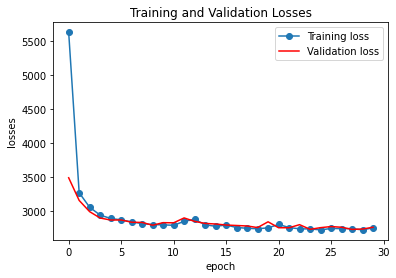

In [64]:
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

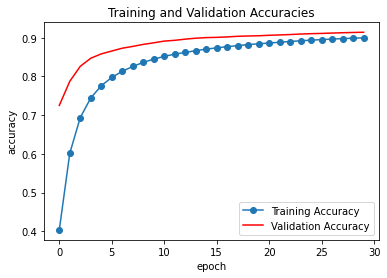

In [65]:
plt.plot(train_acces,'-o', label="Training Accuracy")
plt.plot(val_acces,'-r',  label="Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

---
Latent Space Visualization

Latent Space Visualization


<ipython-input-66-f55a78b44181>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('gist_rainbow', num_classes))


Latent Space Image 1 stored.
Latent Space Image 2 stored.
Latent Space Image 3 stored.
Latent Space Image 4 stored.
Latent Space Image 5 stored.
Latent Space Image 6 stored.
Latent Space Image 7 stored.
Latent Space Image 8 stored.
Latent Space Image 9 stored.
Latent Space Image 10 stored.
Latent Space Image 11 stored.
Latent Space Image 12 stored.
Latent Space Image 13 stored.
Latent Space Image 14 stored.
Latent Space Image 15 stored.
Latent Space Image 16 stored.
Latent Space Image 17 stored.
Latent Space Image 18 stored.
Latent Space Image 19 stored.
Latent Space Image 20 stored.
Latent Space Image 21 stored.
Latent Space Image 22 stored.
Latent Space Image 23 stored.
Latent Space Image 24 stored.
Latent Space Image 25 stored.
Latent Space Image 26 stored.
Latent Space Image 27 stored.
Latent Space Image 28 stored.
Latent Space Image 29 stored.
Latent Space Image 30 stored.

Latent Space Gif being created...



<ipython-input-66-f55a78b44181>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images


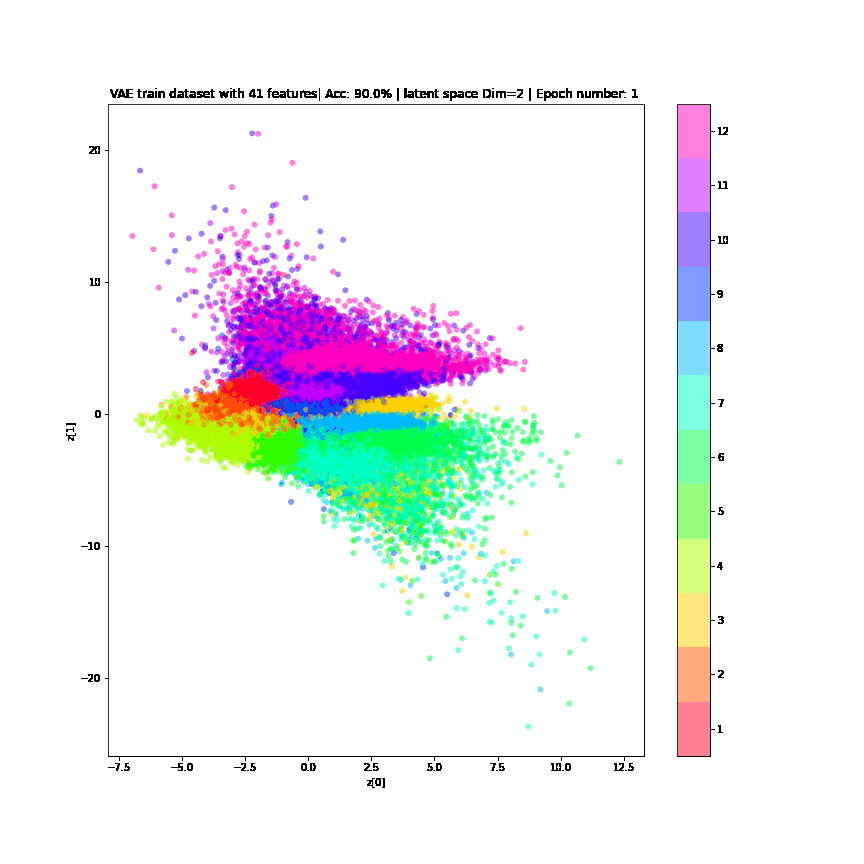

In [66]:
print("Latent Space Visualization")
for i in range (num_epochs):
  fig = plt.figure(figsize=(12,12))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()

  #Experiment 1
  plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('gist_rainbow', num_classes))
  cb = plt.colorbar(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],values=[1,2,3,4,5,6,7,8,9,10,11,12])
  #Experiment 3
  # plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
  #             cmap=plt.cm.get_cmap('hsv', 23))
  #cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  cb.ax.tick_params(labelsize=10)
  # plt.xlim(-5, 5)
  # plt.ylim(-5, 5)
  plt.xticks(fontsize= 10)
  plt.yticks(fontsize= 10)
  plt.xlabel('z[0]', fontsize= 10)
  plt.ylabel('z[1]', fontsize= 10)
  plt.title(f'VAE train dataset with {input_dim} features| Acc: {train_acc*100:.1f}% | latent space Dim={latent_dim} | Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i:001}" + ".png")
  print(f"Latent Space Image {i+1} stored.")
print()
print("Latent Space Gif being created...")
print()

import imageio
gif = []
for i in range(num_epochs):
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave(f"/content/Latent_Space_and_Number_Features_{input_dim}.gif",gif)

from IPython.display import Image

fname = f'/content/Latent_Space_and_Number_Features_{input_dim}.gif'
Image(open(fname, 'rb').read())  # local

---
VAE Confusion Matrix
---

              precision    recall  f1-score   support

           1       0.95      0.99      0.97      1296
           2       0.96      0.95      0.96      1306
           3       0.99      0.56      0.71      1286
           4       0.71      0.98      0.82      1326
           5       0.94      0.98      0.96      1335
           6       0.96      0.99      0.97      1408
           7       0.96      0.95      0.96      1301
           8       0.95      0.96      0.95      1300
           9       0.99      0.92      0.95      1393
          10       0.95      0.99      0.97      1368
          11       0.96      0.96      0.96      1249
          12       0.98      0.96      0.97      1304

    accuracy                           0.93     15872
   macro avg       0.94      0.93      0.93     15872
weighted avg       0.94      0.93      0.93     15872



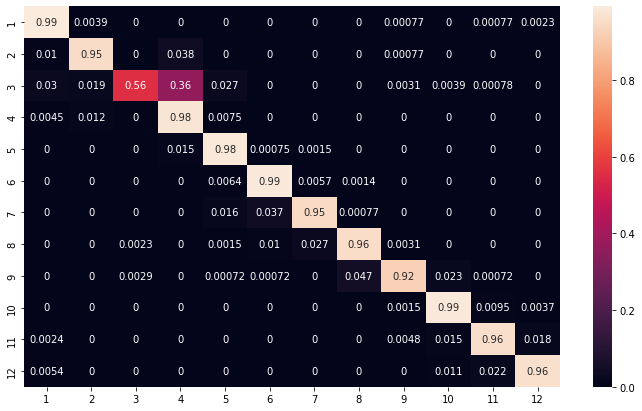

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
  x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)
  classified = (torch.max(torch.exp(classified), 1)[1]).data.cpu().numpy()
  y_pred.extend(classified) # Save Prediction
        
  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12',)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

from sklearn import metrics
from sklearn.metrics import classification_report
label_names = ['1', '2', '3', '4','5','6','7','8','9','10','11','12']
print(classification_report(y_true, y_pred,target_names=label_names))